

# Exercise: Day-Ahead Consumption Prediction for the ETSEIB Building


In this exercise, the goal is to train a machine learning regression model to predict the next day’s energy consumption for the ETSEIB building at UPC.

The [SIRENA](https://upcsirena.app.dexma.com/analysis/consumption/display.htm) tool (Information System for Energy and Water Resources of UPC) is used for monitoring and evaluating energy and resource usage across UPC. It tracks the consumption of electricity, gas, and water, along with photovoltaic energy production and indoor air quality across UPC facilities.


<img src="Figures/sirena-upc.png" alt="Drawing" style="width: 800px;"/>


* **Objective**
Develop a model that forecasts the ETSEIB building’s energy consumption (in kWh) for the following day. The model will rely on historical consumption data and meteorological information to make accurate predictions.

* **Data Sources**
    * Consumption Data: Historical data on electricity, gas, and water consumption can be downloaded from the SIRENA platform, which centralizes utility usage data for UPC.

    * Weather Data: Meteorological data is available from Spain’s Open Data service, AEMET. This data includes relevant weather information, which can be a key factor in predicting energy consumption patterns.




---

<div style="background-color: #ffffe0; padding: 15px; border-radius: 5px;">

# **Let's build a first model!**

</div>

---

In [2]:
# We import libraries
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Suppress FutureWarnings


# We load the input data set
dataset = pd.read_excel('Data/etseib-consumption.xlsx')


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 1. Understanding the Data
    
</div>

> It is necessary to visualize and understand the data we are going to work with, as well as to know its characteristics.
> 
> - How many rows do we have? How many attributes are there in the data?
> - What are these attributes?
> - Is there any missing data?
> - Statistical summary of the input data set.


In [4]:
### Dataset shape
dataset.shape

(10369, 3)

In [6]:
# First 5 rows
dataset.head()

Datetime                Hour  ETSEIB_consumption
0 2023-09-01 00:00:00 2023-09-01 00:00:00                 100
1 2023-09-01 01:00:00 2023-09-01 01:00:00                  98
2 2023-09-01 02:00:00 2023-09-01 02:00:00                  97
3 2023-09-01 03:00:00 2023-09-01 03:00:00                  96
4 2023-09-01 04:00:00 2023-09-01 04:00:00                  96


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Let's delete the repeated column 
    
</div>




In [10]:
dataset.drop(columns=["Hour"], inplace=True)
dataset

Datetime  ETSEIB_consumption
0     2023-09-01 00:00:00                 100
1     2023-09-01 01:00:00                  98
2     2023-09-01 02:00:00                  97
3     2023-09-01 03:00:00                  96
4     2023-09-01 04:00:00                  96
...                   ...                 ...
10364 2024-11-05 19:00:00                 282
10365 2024-11-05 20:00:00                 217
10366 2024-11-05 21:00:00                 168
10367 2024-11-05 22:00:00                 143
10368 2024-11-05 23:00:00                 134

[10369 rows x 2 columns]

In [12]:
# data format
dataset.dtypes

Datetime              datetime64[ns]
ETSEIB_consumption             int64
dtype: object

In [14]:
# Check for missing data
dataset.isna().sum()

Datetime              0
ETSEIB_consumption    0
dtype: int64

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Plot the ETSEIB dataset consumption
    
</div>


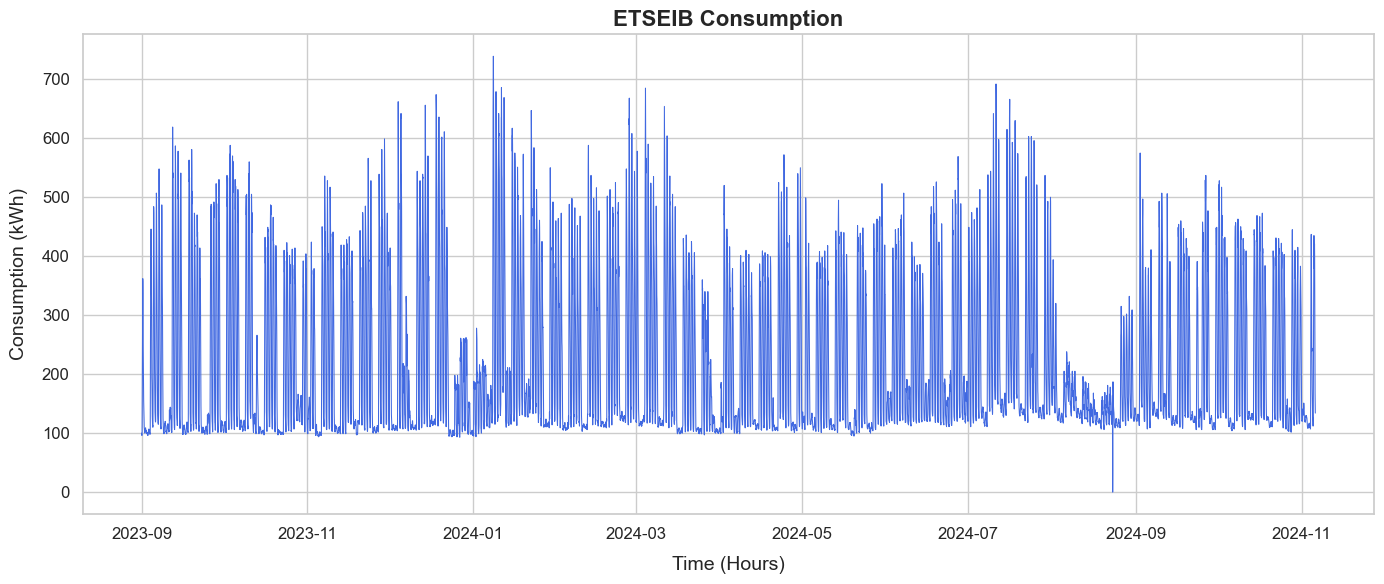

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a larger figure for better clarity
plt.figure(figsize=(14, 6))

sns.lineplot(data=dataset, x='Datetime', y='ETSEIB_consumption', color='royalblue', linewidth=0.75)

# Title and labels
plt.title('ETSEIB Consumption', fontsize=16, weight='bold')
plt.xlabel('Time (Hours)', fontsize=14, labelpad=10)
plt.ylabel('Consumption (kWh)', fontsize=14, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=12)

# Increase y-axis label font size for better visibility
plt.yticks(fontsize=12)

# Show gridlines for better readability of the plot
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
dataset.describe()

Datetime  ETSEIB_consumption
count                          10369        10369.000000
mean   2024-04-03 23:37:14.159513856          219.148713
min              2023-09-01 00:00:00            0.000000
25%              2023-12-17 23:00:00          117.000000
50%              2024-04-04 00:00:00          144.000000
75%              2024-07-21 00:00:00          321.000000
max              2024-11-05 23:00:00          739.000000
std                              NaN          135.739199

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Create the ProfileReport() 
    
</div>


In [22]:
from pandas_profiling import ProfileReport
##pandas profiling
#apply ProfileReport
profile = ProfileReport(dataset, title='Profile Report')

C:\Users\vikra\AppData\Local\Temp\ipykernel_15384\676426928.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [24]:
profile.to_file("your_report2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

We have noticed that there is a row that is repeated. We delete it    
</div>




In [26]:
# Remove duplicate rows
dataset = dataset.drop_duplicates()


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 2. Exploratory Data Analisys (EDA). Visualize the data. 
    
</div>

> Exploratory Data Analysis is the process of analyzing and visualizing datasets to summarize their main characteristics, with the help of graphical representations. It is a critical step in the machine learning pipeline because it helps to understand the structure, patterns, and relationships within the data before applying machine learning models.

> The **goal** of EDA is to gain insights into the data, identify any issues such as missing values or outliers, and make informed decisions about data preprocessing, feature engineering, and model selection.


> ### Histogram,  density plots and boxplots

> * **Histograms** are useful when you need to see the actual count of data points in each range and when you want to visualize the data's distribution with specific bins.

> * **Density** plots are better when you want to visualize the overall shape of the data's distribution and avoid the randomness introduced by binning in histograms. Density plots are also great for comparing distributions between groups or variables because they provide a smooth estimate without the arbitrary choice of bin size.

> * A **boxplot** is a graphical representation of the distribution of a dataset, highlighting its median, interquartile range (IQR), and outliers. In machine learning, boxplots are useful for detecting outliers, understanding data distribution, and guiding feature engineering.

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Histogram
    
</div>


<Axes: xlabel='ETSEIB_consumption', ylabel='Count'>

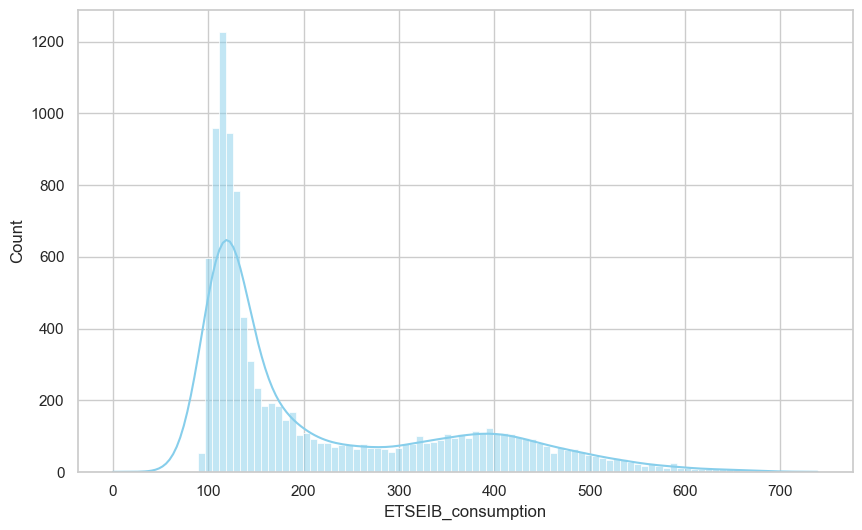

In [31]:

plt.figure(figsize=(10, 6))
sns.histplot(dataset["ETSEIB_consumption"], kde=True, bins=100, color='skyblue')

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Density plots
    
</div>

> * Let's compare the distributions for each month and compare them with the overall dataset
> * In order to do so, we need to create a new input feature: **month**

In [34]:
# create a new input feature: month
dataset['month'] = dataset['Datetime'].dt.month

C:\Users\vikra\AppData\Local\Temp\ipykernel_15384\1939275059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['month'] = dataset['Datetime'].dt.month


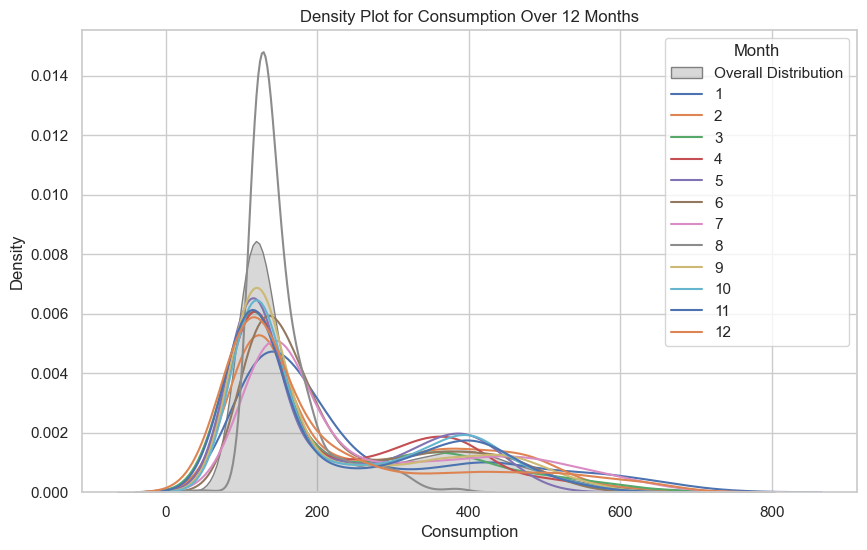

In [36]:
# Plotting Density Plot for 12 Months


plt.figure(figsize=(10, 6))
sns.kdeplot(data=dataset, x='ETSEIB_consumption', fill=True, color='gray', alpha=0.3, label='Overall Distribution')

# Loop through each month
for month in range(1, 13):
    sns.kdeplot(data=dataset[dataset['month'] == month], x='ETSEIB_consumption', 
                fill=False, common_norm=False, label=month)
    
plt.title('Density Plot for Consumption Over 12 Months')
plt.xlabel('Consumption')
plt.ylabel('Density')
plt.legend(title='Month')
plt.show()


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;  margin-top: 25px;">
Plot the monthly distributions separetly    
</div>

> If we want to see more clearly the distribution of each month, we can also plot them separately. It can be seen that for the month of August, the distribution is atypical compared to the rest of the months.

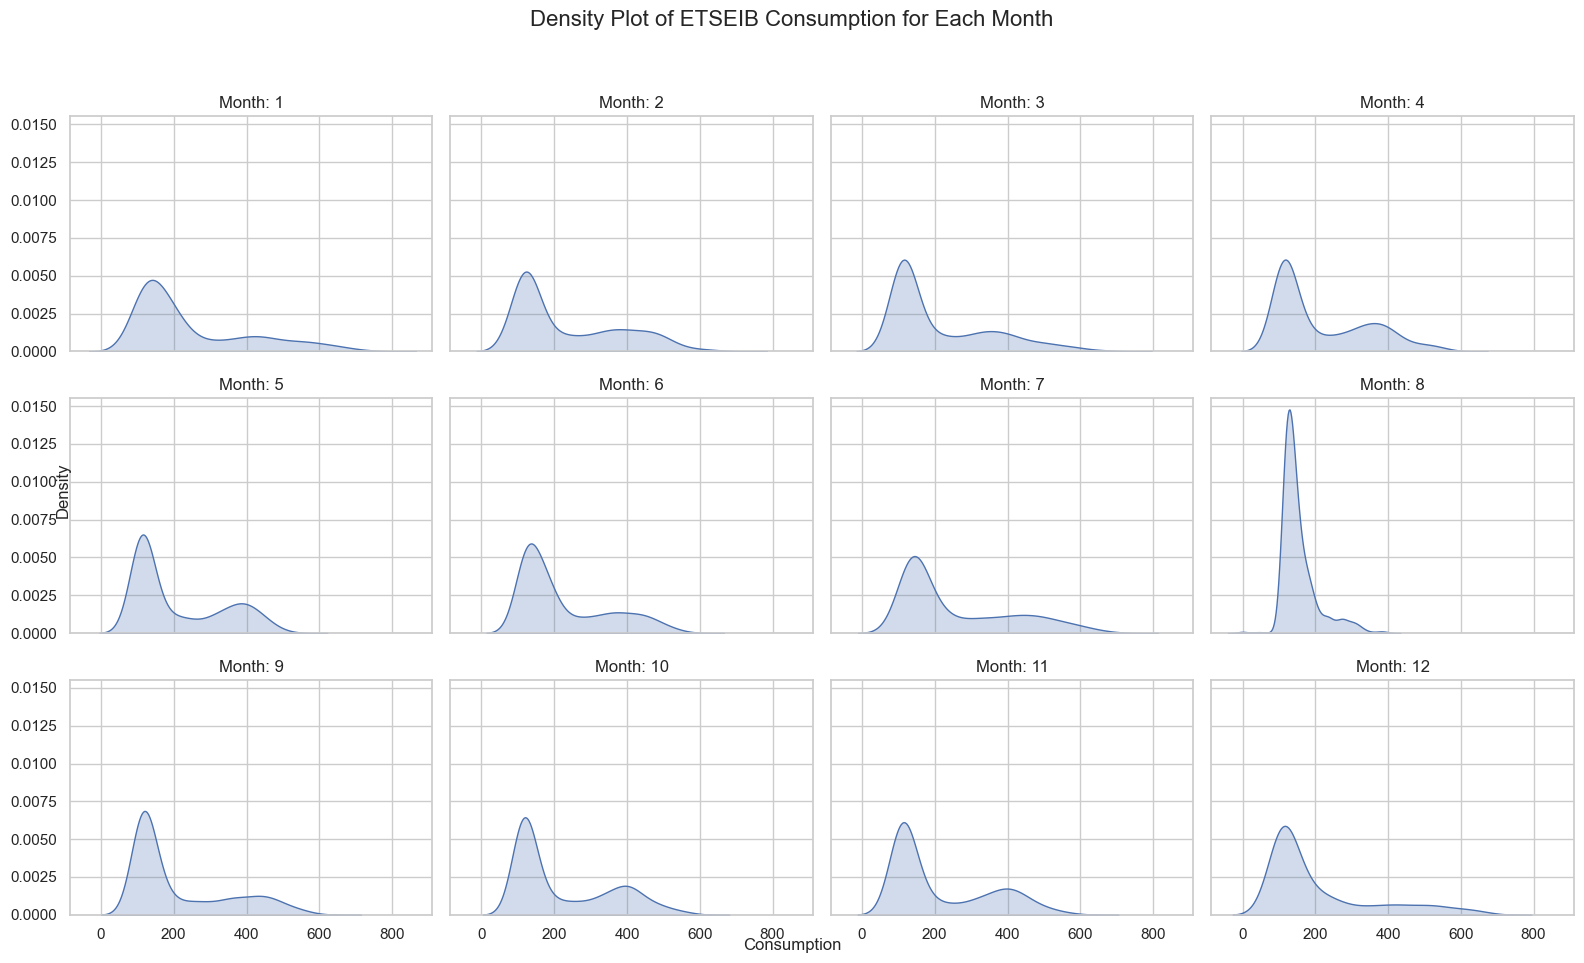

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set up the figure with 12 subplots (3 rows x 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharex=True, sharey=True)
fig.suptitle('Density Plot of ETSEIB Consumption for Each Month', fontsize=16)

# Loop through each month and create a density plot in each subplot
for month in range(1, 13):
    ax = axes[(month-1) // 4, (month-1) % 4]  # Determine subplot position
    sns.kdeplot(
        data=dataset[dataset['month'] == month], 
        x='ETSEIB_consumption', 
        fill=True, 
        common_norm=False, 
        ax=ax
    )
    ax.set_title(f'Month: {month}')  # Title each subplot with the month
    ax.set_xlabel('')  # Remove x-label to keep it clean
    ax.set_ylabel('')  # Remove y-label to keep it clean

# Set common labels
fig.text(0.5, 0.04, 'Consumption', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for titles
plt.show()

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Boxplot
    
</div>

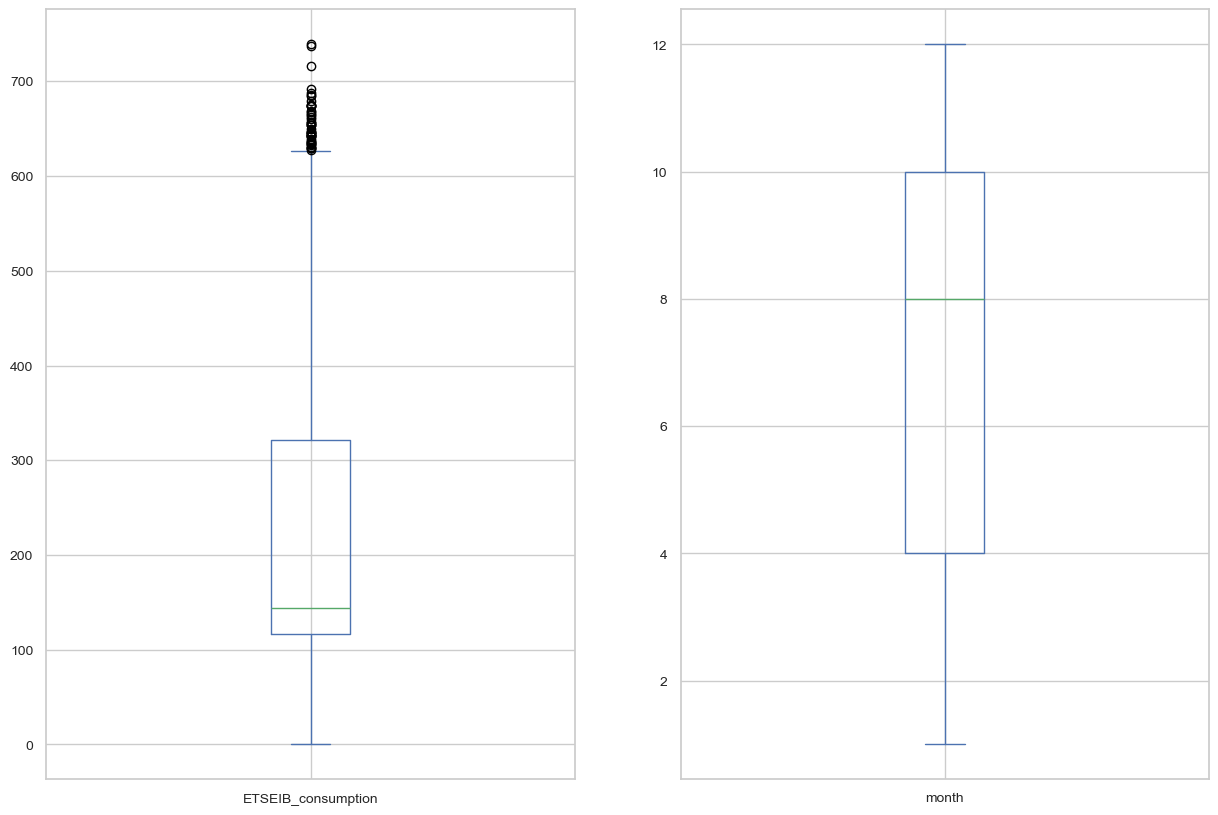

In [42]:

atributos_boxplot = dataset.plot(kind='box', subplots=True, figsize=(15, 10), sharex=False,
                                 sharey=False, fontsize=10)
plt.show()




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

#### Can we create more new meaninful features? 
    
</div>

> In order to analyze the consumption behavior of the ETSEIB, we will add new input variables to plot the different distributions of the data by month, to see the differences in consumption between weekdays and weekends, etc.

In [45]:

# Extract Hour, Day of Week
dataset.loc[:,'day_of_week'] = dataset['Datetime'].dt.weekday
dataset.loc[:,'hour'] = dataset['Datetime'].dt.hour

C:\Users\vikra\AppData\Local\Temp\ipykernel_15384\3065506801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'day_of_week'] = dataset['Datetime'].dt.weekday
C:\Users\vikra\AppData\Local\Temp\ipykernel_15384\3065506801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'hour'] = dataset['Datetime'].dt.hour


In [47]:
dataset

Datetime  ETSEIB_consumption  month  day_of_week  hour
0     2023-09-01 00:00:00                 100      9            4     0
1     2023-09-01 01:00:00                  98      9            4     1
2     2023-09-01 02:00:00                  97      9            4     2
3     2023-09-01 03:00:00                  96      9            4     3
4     2023-09-01 04:00:00                  96      9            4     4
...                   ...                 ...    ...          ...   ...
10364 2024-11-05 19:00:00                 282     11            1    19
10365 2024-11-05 20:00:00                 217     11            1    20
10366 2024-11-05 21:00:00                 168     11            1    21
10367 2024-11-05 22:00:00                 143     11            1    22
10368 2024-11-05 23:00:00                 134     11            1    23

[10368 rows x 5 columns]

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

Plotting Weekend vs Weekdays Comparison
</div>

> Assuming that weekdays are Monday (0) to Friday (4) and weekends are Saturday (5) and Sunday (6)


C:\Users\vikra\AppData\Local\Temp\ipykernel_15384\3405072595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:,'is_weekend'] = dataset['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


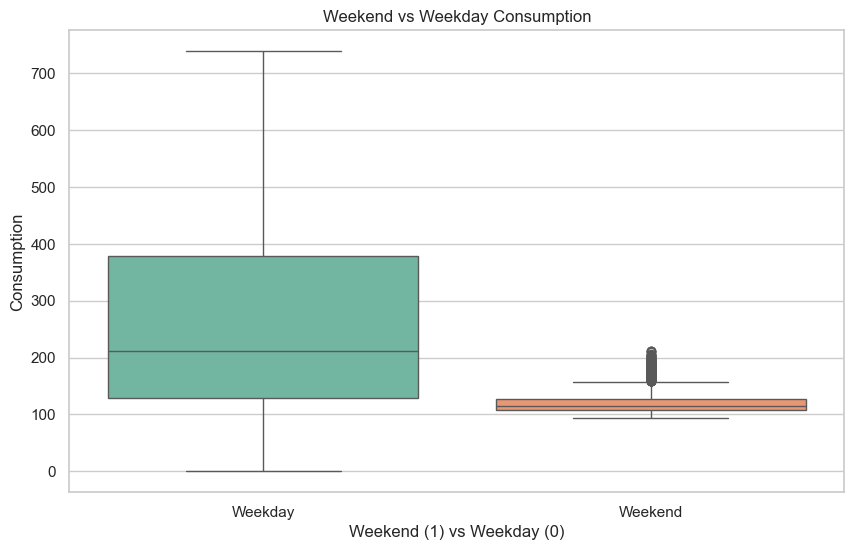

In [50]:

dataset.loc[:,'is_weekend'] = dataset['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Group the data by 'is_weekend' and plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='ETSEIB_consumption', data=dataset, palette='Set2')
plt.title('Weekend vs Weekday Consumption')
plt.xlabel('Weekend (1) vs Weekday (0)')
plt.ylabel('Consumption')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Plot distribution of data for weekdays and weekends
</div>



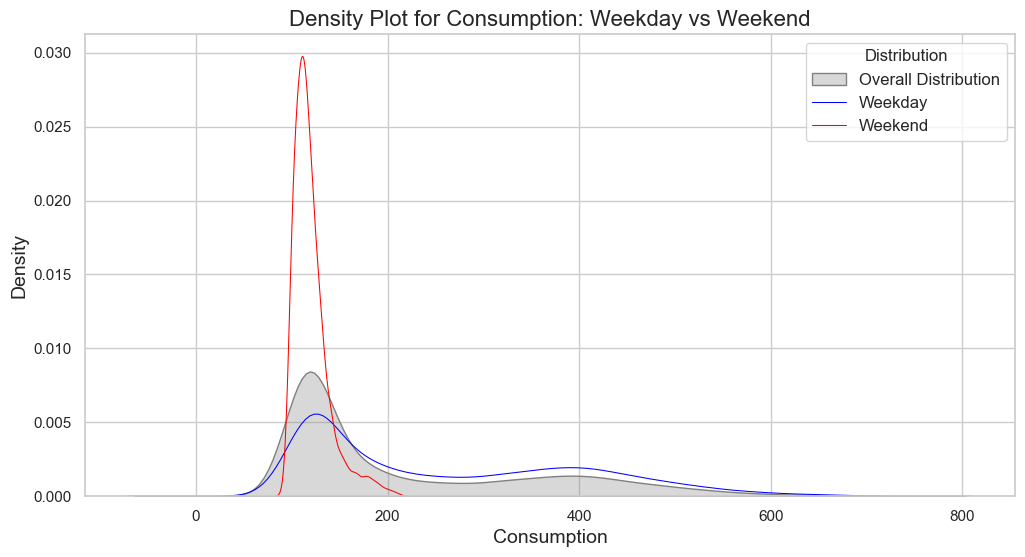

In [53]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting Weekend vs Weekdays Comparison (Density Plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=dataset, x='ETSEIB_consumption', fill=True, color='gray', alpha=0.3, label='Overall Distribution')

# Plot weekday consumption distribution
sns.kdeplot(data=dataset[dataset['is_weekend'] == 0], x='ETSEIB_consumption', 
            fill=False, color='blue', label='Weekday', linewidth = 0.75)

# Plot weekend consumption distribution
sns.kdeplot(data=dataset[dataset['is_weekend'] == 1], x='ETSEIB_consumption', 
            fill=False, color='red', label='Weekend', linewidth = 0.75)

# Title and labels
plt.title('Density Plot for Consumption: Weekday vs Weekend', fontsize=16)
plt.xlabel('Consumption', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Distribution', fontsize=12)  # Adding a legend
plt.show()

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

DETECT outliers
    
</div>

> * First, we will DETECT when they occur.
> * They will not be removed for now, as we will use lag variables in the future.

In [56]:
from scipy import stats

threshold = 3   # Mark as outlier if Z-score > threshold

dataset_outliers = dataset.copy()

# Detect outliers using Z-score
dataset_outliers['z_score'] = stats.zscore(dataset['ETSEIB_consumption'])
dataset_outliers['outlier'] = np.abs(dataset_outliers['z_score']) > threshold 
dataset_outliers

Datetime  ETSEIB_consumption  month  day_of_week  hour  \
0     2023-09-01 00:00:00                 100      9            4     0   
1     2023-09-01 01:00:00                  98      9            4     1   
2     2023-09-01 02:00:00                  97      9            4     2   
3     2023-09-01 03:00:00                  96      9            4     3   
4     2023-09-01 04:00:00                  96      9            4     4   
...                   ...                 ...    ...          ...   ...   
10364 2024-11-05 19:00:00                 282     11            1    19   
10365 2024-11-05 20:00:00                 217     11            1    20   
10366 2024-11-05 21:00:00                 168     11            1    21   
10367 2024-11-05 22:00:00                 143     11            1    22   
10368 2024-11-05 23:00:00                 134     11            1    23   

       is_weekend   z_score  outlier  
0               0 -0.877869    False  
1               0 -0.892603    False  
2               0 -0.899970    False  
3               0 -0.907338    False  
4               0 -0.907338    False  
...           ...       ...      ...  
10364           0  0.462972    False  
10365           0 -0.015900    False  
10366           0 -0.376895    False  
10367           0 -0.561077    False  
10368           0 -0.627382    False  

[10368 rows x 8 columns]


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

When do the outliers occur? 
</div>


> Month vs Weekday

> Month vs Hour

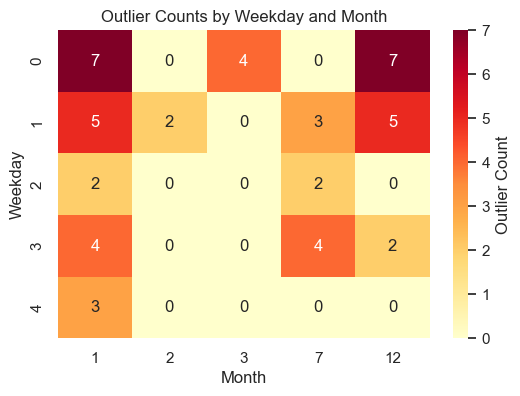

In [59]:
# Month vs Weekday
outlier_counts = dataset_outliers[dataset_outliers['outlier']].groupby(['day_of_week', 'month']).size().unstack(fill_value=0)

# Plot heatmap of outlier counts
plt.figure(figsize=(6, 4))
sns.heatmap(outlier_counts, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Outlier Count'})
plt.title('Outlier Counts by Weekday and Month')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.show()

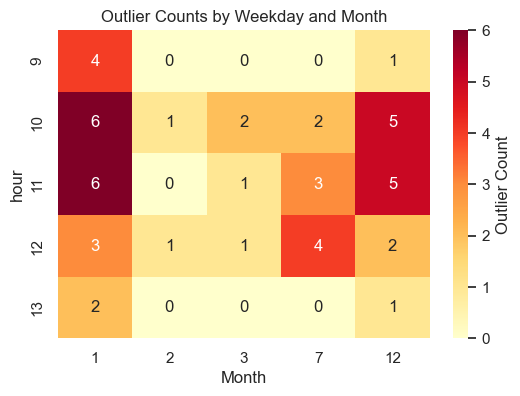

In [61]:
# Month vs Hour
outlier_counts = dataset_outliers[dataset_outliers['outlier']].groupby(['hour', 'month']).size().unstack(fill_value=0)

# Plot heatmap of outlier counts
plt.figure(figsize=(6, 4))
sns.heatmap(outlier_counts, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Outlier Count'})
plt.title('Outlier Counts by Weekday and Month')
plt.xlabel('Month')
plt.ylabel('hour')
plt.show()

<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Correlation matrix
    
</div>

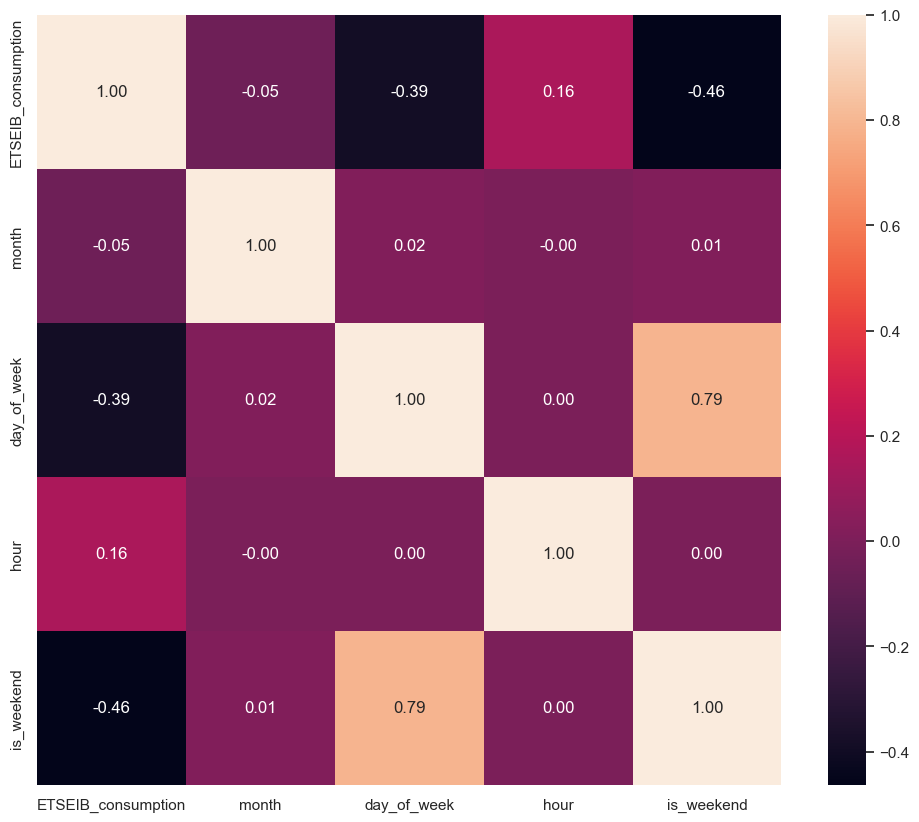

In [64]:
### Seaborn visualization library
import seaborn as sns

# Calculate the correlation matrix
corr = dataset.iloc[:,1:].corr(method='pearson') 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 3. Data Preparation
    
</div>

> * Data cleaning
> * Feature selection (create/delete/select)


In [67]:

# Apply one-hot encoding to the 'hour' column and day_of_the_week
dataset = pd.get_dummies(dataset, columns=['day_of_week'], prefix='day_of_week',  dtype=float)
dataset = pd.get_dummies(dataset, columns=['hour'], prefix='hour',  dtype=float)

In [69]:
dataset

Datetime  ETSEIB_consumption  month  is_weekend  \
0     2023-09-01 00:00:00                 100      9           0   
1     2023-09-01 01:00:00                  98      9           0   
2     2023-09-01 02:00:00                  97      9           0   
3     2023-09-01 03:00:00                  96      9           0   
4     2023-09-01 04:00:00                  96      9           0   
...                   ...                 ...    ...         ...   
10364 2024-11-05 19:00:00                 282     11           0   
10365 2024-11-05 20:00:00                 217     11           0   
10366 2024-11-05 21:00:00                 168     11           0   
10367 2024-11-05 22:00:00                 143     11           0   
10368 2024-11-05 23:00:00                 134     11           0   

       day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                0.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
10364            0.0            1.0            0.0            0.0   
10365            0.0            1.0            0.0            0.0   
10366            0.0            1.0            0.0            0.0   
10367            0.0            1.0            0.0            0.0   
10368            0.0            1.0            0.0            0.0   

       day_of_week_4  day_of_week_5  ...  hour_14  hour_15  hour_16  hour_17  \
0                1.0            0.0  ...      0.0      0.0      0.0      0.0   
1                1.0            0.0  ...      0.0      0.0      0.0      0.0   
2                1.0            0.0  ...      0.0      0.0      0.0      0.0   
3                1.0            0.0  ...      0.0      0.0      0.0      0.0   
4                1.0            0.0  ...      0.0      0.0      0.0      0.0   
...              ...            ...  ...      ...      ...      ...      ...   
10364            0.0            0.0  ...      0.0      0.0      0.0      0.0   
10365            0.0            0.0  ...      0.0      0.0      0.0      0.0   
10366            0.0            0.0  ...      0.0      0.0      0.0      0.0   
10367            0.0            0.0  ...      0.0      0.0      0.0      0.0   
10368            0.0            0.0  ...      0.0      0.0      0.0      0.0   

       hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  
0          0.0      0.0      0.0      0.0      0.0      0.0  
1          0.0      0.0      0.0      0.0      0.0      0.0  
2          0.0      0.0      0.0      0.0      0.0      0.0  
3          0.0      0.0      0.0      0.0      0.0      0.0  
4          0.0      0.0      0.0      0.0      0.0      0.0  
...        ...      ...      ...      ...      ...      ...  
10364      0.0      1.0      0.0      0.0      0.0      0.0  
10365      0.0      0.0      1.0      0.0      0.0      0.0  
10366      0.0      0.0      0.0      1.0      0.0      0.0  
10367      0.0      0.0      0.0      0.0      1.0      0.0  
10368      0.0      0.0      0.0      0.0      0.0      1.0  

[10368 rows x 35 columns]



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Create lag variables. Why are they important?
    
</div>

> * Capturing Temporal Dependence: Many datasets, especially time series data, exhibit autocorrelation—where past values of a variable influence its future values. By incorporating lag variables, regression models can account for this temporal relationship.
> * Improving Forecasting: In time series forecasting, lag variables help to make predictions based on prior values. This is particularly important for variables that follow cyclical patterns or trends over time.

In [72]:
# Create lag variables for the previous day and two days ago
dataset['Lag_1_day'] = dataset['ETSEIB_consumption'].shift(24)  # Lag of 24 hours (1 day)
dataset['Lag_2_days'] = dataset['ETSEIB_consumption'].shift(48)  # Lag of 48 hours (2 days)
dataset['Lag_7_days'] = dataset['ETSEIB_consumption'].shift(168)  # Lag of 48 hours (2 days)
dataset['Lag_14_days'] = dataset['ETSEIB_consumption'].shift(336)  # Lag of 48 hours (2 days)
dataset['Lag_21_days'] = dataset['ETSEIB_consumption'].shift(504)  # Lag of 48 hours (2 days)

In [74]:
dataset

Datetime  ETSEIB_consumption  month  is_weekend  \
0     2023-09-01 00:00:00                 100      9           0   
1     2023-09-01 01:00:00                  98      9           0   
2     2023-09-01 02:00:00                  97      9           0   
3     2023-09-01 03:00:00                  96      9           0   
4     2023-09-01 04:00:00                  96      9           0   
...                   ...                 ...    ...         ...   
10364 2024-11-05 19:00:00                 282     11           0   
10365 2024-11-05 20:00:00                 217     11           0   
10366 2024-11-05 21:00:00                 168     11           0   
10367 2024-11-05 22:00:00                 143     11           0   
10368 2024-11-05 23:00:00                 134     11           0   

       day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                0.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
10364            0.0            1.0            0.0            0.0   
10365            0.0            1.0            0.0            0.0   
10366            0.0            1.0            0.0            0.0   
10367            0.0            1.0            0.0            0.0   
10368            0.0            1.0            0.0            0.0   

       day_of_week_4  day_of_week_5  ...  hour_19  hour_20  hour_21  hour_22  \
0                1.0            0.0  ...      0.0      0.0      0.0      0.0   
1                1.0            0.0  ...      0.0      0.0      0.0      0.0   
2                1.0            0.0  ...      0.0      0.0      0.0      0.0   
3                1.0            0.0  ...      0.0      0.0      0.0      0.0   
4                1.0            0.0  ...      0.0      0.0      0.0      0.0   
...              ...            ...  ...      ...      ...      ...      ...   
10364            0.0            0.0  ...      1.0      0.0      0.0      0.0   
10365            0.0            0.0  ...      0.0      1.0      0.0      0.0   
10366            0.0            0.0  ...      0.0      0.0      1.0      0.0   
10367            0.0            0.0  ...      0.0      0.0      0.0      1.0   
10368            0.0            0.0  ...      0.0      0.0      0.0      0.0   

       hour_23  Lag_1_day  Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  
0          0.0        NaN         NaN         NaN          NaN          NaN  
1          0.0        NaN         NaN         NaN          NaN          NaN  
2          0.0        NaN         NaN         NaN          NaN          NaN  
3          0.0        NaN         NaN         NaN          NaN          NaN  
4          0.0        NaN         NaN         NaN          NaN          NaN  
...        ...        ...         ...         ...          ...          ...  
10364      0.0      176.0       114.0       249.0        213.0        216.0  
10365      0.0      162.0       113.0       194.0        160.0        171.0  
10366      0.0      152.0       111.0       156.0        133.0        144.0  
10367      0.0      133.0       110.0       132.0        123.0        132.0  
10368      1.0      127.0       111.0       128.0        124.0        126.0  

[10368 rows x 40 columns]

In [76]:
dataset.dropna(inplace=True)

In [78]:
dataset

Datetime  ETSEIB_consumption  month  is_weekend  \
504   2023-09-22 00:00:00                 113      9           0   
505   2023-09-22 01:00:00                 113      9           0   
506   2023-09-22 02:00:00                 112      9           0   
507   2023-09-22 03:00:00                 105      9           0   
508   2023-09-22 04:00:00                 103      9           0   
...                   ...                 ...    ...         ...   
10364 2024-11-05 19:00:00                 282     11           0   
10365 2024-11-05 20:00:00                 217     11           0   
10366 2024-11-05 21:00:00                 168     11           0   
10367 2024-11-05 22:00:00                 143     11           0   
10368 2024-11-05 23:00:00                 134     11           0   

       day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
504              0.0            0.0            0.0            0.0   
505              0.0            0.0            0.0            0.0   
506              0.0            0.0            0.0            0.0   
507              0.0            0.0            0.0            0.0   
508              0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
10364            0.0            1.0            0.0            0.0   
10365            0.0            1.0            0.0            0.0   
10366            0.0            1.0            0.0            0.0   
10367            0.0            1.0            0.0            0.0   
10368            0.0            1.0            0.0            0.0   

       day_of_week_4  day_of_week_5  ...  hour_19  hour_20  hour_21  hour_22  \
504              1.0            0.0  ...      0.0      0.0      0.0      0.0   
505              1.0            0.0  ...      0.0      0.0      0.0      0.0   
506              1.0            0.0  ...      0.0      0.0      0.0      0.0   
507              1.0            0.0  ...      0.0      0.0      0.0      0.0   
508              1.0            0.0  ...      0.0      0.0      0.0      0.0   
...              ...            ...  ...      ...      ...      ...      ...   
10364            0.0            0.0  ...      1.0      0.0      0.0      0.0   
10365            0.0            0.0  ...      0.0      1.0      0.0      0.0   
10366            0.0            0.0  ...      0.0      0.0      1.0      0.0   
10367            0.0            0.0  ...      0.0      0.0      0.0      1.0   
10368            0.0            0.0  ...      0.0      0.0      0.0      0.0   

       hour_23  Lag_1_day  Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  
504        0.0      117.0       118.0       123.0        120.0        100.0  
505        0.0      118.0       115.0       121.0        112.0         98.0  
506        0.0      115.0       110.0       116.0        111.0         97.0  
507        0.0      108.0       105.0       110.0        110.0         96.0  
508        0.0      107.0       105.0       108.0        107.0         96.0  
...        ...        ...         ...         ...          ...          ...  
10364      0.0      176.0       114.0       249.0        213.0        216.0  
10365      0.0      162.0       113.0       194.0        160.0        171.0  
10366      0.0      152.0       111.0       156.0        133.0        144.0  
10367      0.0      133.0       110.0       132.0        123.0        132.0  
10368      1.0      127.0       111.0       128.0        124.0        126.0  

[9864 rows x 40 columns]

In [80]:
# Set the datetime column as index
dataset_v1 = dataset.set_index('Datetime')
dataset_v1

ETSEIB_consumption  month  is_weekend  day_of_week_0  \
Datetime                                                                    
2023-09-22 00:00:00                 113      9           0            0.0   
2023-09-22 01:00:00                 113      9           0            0.0   
2023-09-22 02:00:00                 112      9           0            0.0   
2023-09-22 03:00:00                 105      9           0            0.0   
2023-09-22 04:00:00                 103      9           0            0.0   
...                                 ...    ...         ...            ...   
2024-11-05 19:00:00                 282     11           0            0.0   
2024-11-05 20:00:00                 217     11           0            0.0   
2024-11-05 21:00:00                 168     11           0            0.0   
2024-11-05 22:00:00                 143     11           0            0.0   
2024-11-05 23:00:00                 134     11           0            0.0   

                     day_of_week_1  day_of_week_2  day_of_week_3  \
Datetime                                                           
2023-09-22 00:00:00            0.0            0.0            0.0   
2023-09-22 01:00:00            0.0            0.0            0.0   
2023-09-22 02:00:00            0.0            0.0            0.0   
2023-09-22 03:00:00            0.0            0.0            0.0   
2023-09-22 04:00:00            0.0            0.0            0.0   
...                            ...            ...            ...   
2024-11-05 19:00:00            1.0            0.0            0.0   
2024-11-05 20:00:00            1.0            0.0            0.0   
2024-11-05 21:00:00            1.0            0.0            0.0   
2024-11-05 22:00:00            1.0            0.0            0.0   
2024-11-05 23:00:00            1.0            0.0            0.0   

                     day_of_week_4  day_of_week_5  day_of_week_6  ...  \
Datetime                                                          ...   
2023-09-22 00:00:00            1.0            0.0            0.0  ...   
2023-09-22 01:00:00            1.0            0.0            0.0  ...   
2023-09-22 02:00:00            1.0            0.0            0.0  ...   
2023-09-22 03:00:00            1.0            0.0            0.0  ...   
2023-09-22 04:00:00            1.0            0.0            0.0  ...   
...                            ...            ...            ...  ...   
2024-11-05 19:00:00            0.0            0.0            0.0  ...   
2024-11-05 20:00:00            0.0            0.0            0.0  ...   
2024-11-05 21:00:00            0.0            0.0            0.0  ...   
2024-11-05 22:00:00            0.0            0.0            0.0  ...   
2024-11-05 23:00:00            0.0            0.0            0.0  ...   

                     hour_19  hour_20  hour_21  hour_22  hour_23  Lag_1_day  \
Datetime                                                                      
2023-09-22 00:00:00      0.0      0.0      0.0      0.0      0.0      117.0   
2023-09-22 01:00:00      0.0      0.0      0.0      0.0      0.0      118.0   
2023-09-22 02:00:00      0.0      0.0      0.0      0.0      0.0      115.0   
2023-09-22 03:00:00      0.0      0.0      0.0      0.0      0.0      108.0   
2023-09-22 04:00:00      0.0      0.0      0.0      0.0      0.0      107.0   
...                      ...      ...      ...      ...      ...        ...   
2024-11-05 19:00:00      1.0      0.0      0.0      0.0      0.0      176.0   
2024-11-05 20:00:00      0.0      1.0      0.0      0.0      0.0      162.0   
2024-11-05 21:00:00      0.0      0.0      1.0      0.0      0.0      152.0   
2024-11-05 22:00:00      0.0      0.0      0.0      1.0      0.0      133.0   
2024-11-05 23:00:00      0.0      0.0      0.0      0.0      1.0      127.0   

                     Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  
Datetime                                                               
2023-09-22 0


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Plot the correlation matrix again
    
</div>

> A correlation matrix is a table that shows the pairwise correlation coefficients between a set of variables (or features) in a dataset. Each element in the matrix represents the correlation between two features.

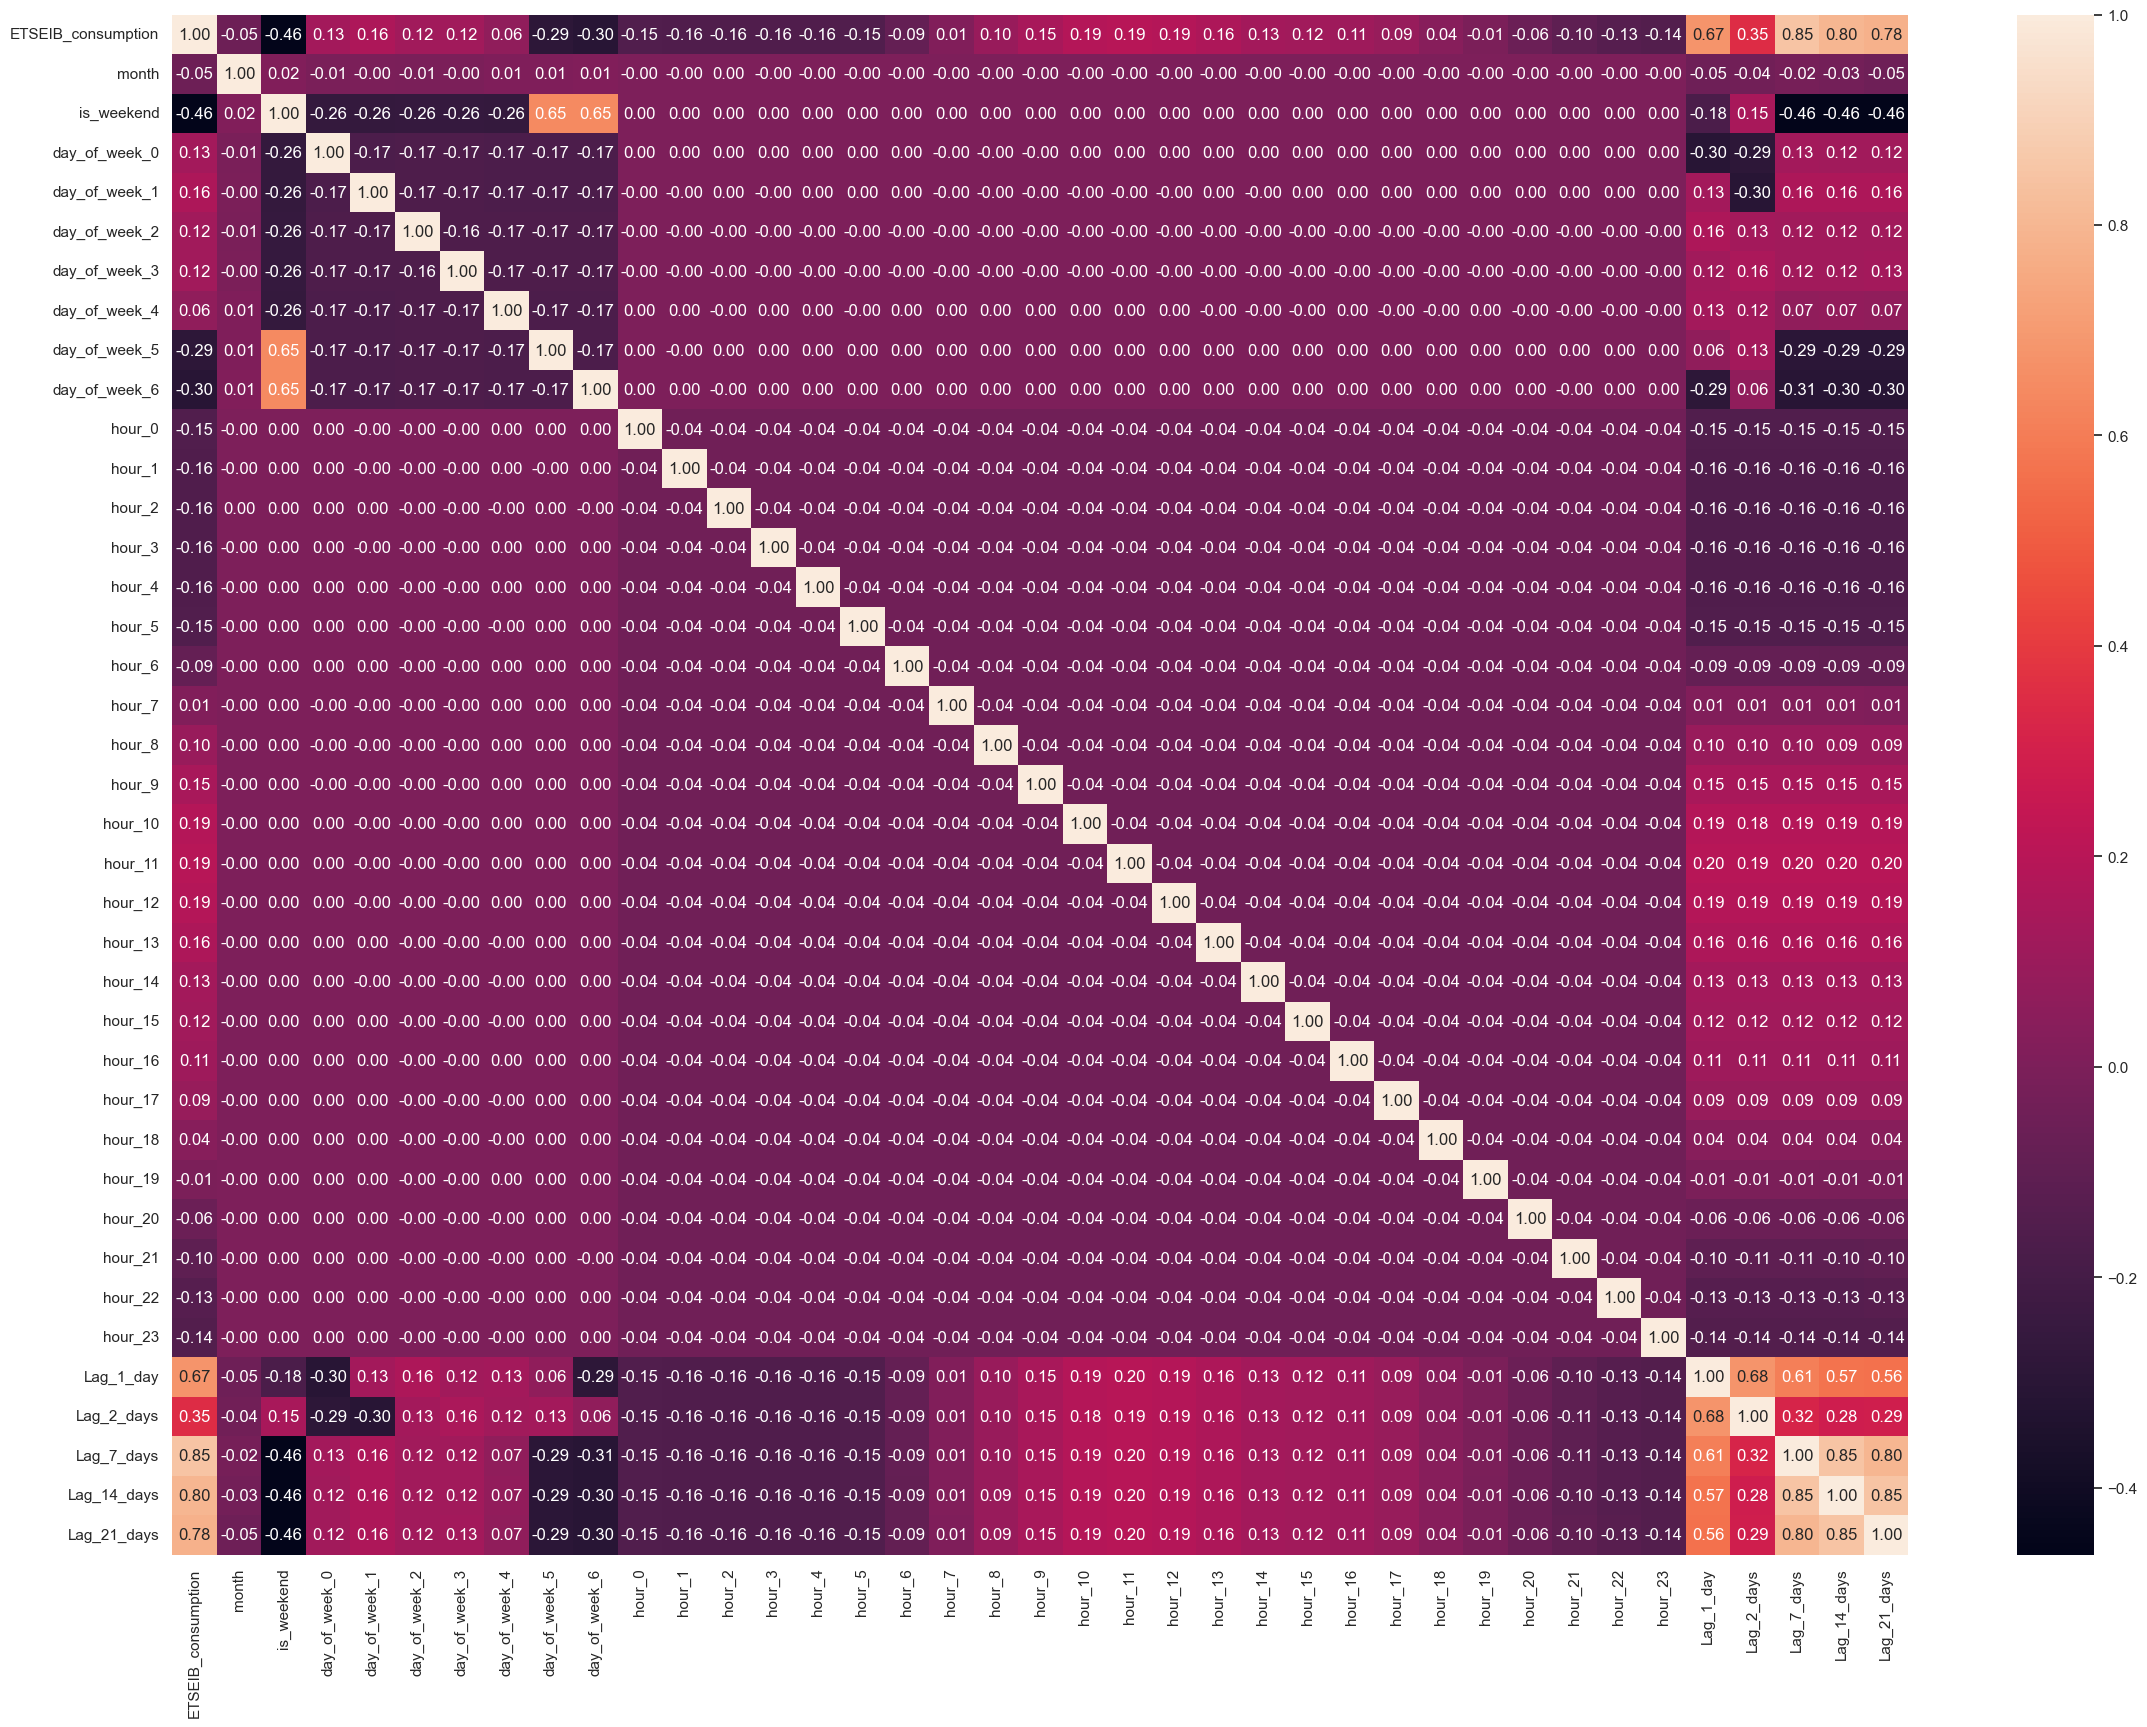

In [83]:
### Seaborn visualization library
import seaborn as sns

# Calculate the correlation matrix
corr = dataset_v1.corr(method='pearson') 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(28, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 4. Split the data
    
</div>

> * Divide the data into attributes: X (features) and tags: y (target).
> * Scale the data


In [86]:
# Features X ; Target y 
X = dataset_v1.drop(['ETSEIB_consumption'], axis=1) 
y = dataset_v1['ETSEIB_consumption']


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


The data are divided into training data ``X_train``, ``y_train``, validation data ``X_val``, ``y_val`` and test data ``X_test``, ``y_test``.
</div>



In [89]:
from sklearn.model_selection import train_test_split

test_size = 0.15  # percentage of the input data that I will use to validate the model

# I divide the data into training, validation and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)

In [91]:
X_val

month  is_weekend  day_of_week_0  day_of_week_1  \
Datetime                                                               
2024-07-14 23:00:00      7           1            0.0            0.0   
2024-07-15 00:00:00      7           0            1.0            0.0   
2024-07-15 01:00:00      7           0            1.0            0.0   
2024-07-15 02:00:00      7           0            1.0            0.0   
2024-07-15 03:00:00      7           0            1.0            0.0   
...                    ...         ...            ...            ...   
2024-09-05 04:00:00      9           0            0.0            0.0   
2024-09-05 05:00:00      9           0            0.0            0.0   
2024-09-05 06:00:00      9           0            0.0            0.0   
2024-09-05 07:00:00      9           0            0.0            0.0   
2024-09-05 08:00:00      9           0            0.0            0.0   

                     day_of_week_2  day_of_week_3  day_of_week_4  \
Datetime                                                           
2024-07-14 23:00:00            0.0            0.0            0.0   
2024-07-15 00:00:00            0.0            0.0            0.0   
2024-07-15 01:00:00            0.0            0.0            0.0   
2024-07-15 02:00:00            0.0            0.0            0.0   
2024-07-15 03:00:00            0.0            0.0            0.0   
...                            ...            ...            ...   
2024-09-05 04:00:00            0.0            1.0            0.0   
2024-09-05 05:00:00            0.0            1.0            0.0   
2024-09-05 06:00:00            0.0            1.0            0.0   
2024-09-05 07:00:00            0.0            1.0            0.0   
2024-09-05 08:00:00            0.0            1.0            0.0   

                     day_of_week_5  day_of_week_6  hour_0  ...  hour_19  \
Datetime                                                   ...            
2024-07-14 23:00:00            0.0            1.0     0.0  ...      0.0   
2024-07-15 00:00:00            0.0            0.0     1.0  ...      0.0   
2024-07-15 01:00:00            0.0            0.0     0.0  ...      0.0   
2024-07-15 02:00:00            0.0            0.0     0.0  ...      0.0   
2024-07-15 03:00:00            0.0            0.0     0.0  ...      0.0   
...                            ...            ...     ...  ...      ...   
2024-09-05 04:00:00            0.0            0.0     0.0  ...      0.0   
2024-09-05 05:00:00            0.0            0.0     0.0  ...      0.0   
2024-09-05 06:00:00            0.0            0.0     0.0  ...      0.0   
2024-09-05 07:00:00            0.0            0.0     0.0  ...      0.0   
2024-09-05 08:00:00            0.0            0.0     0.0  ...      0.0   

                     hour_20  hour_21  hour_22  hour_23  Lag_1_day  \
Datetime                                                             
2024-07-14 23:00:00      0.0      0.0      0.0      1.0      142.0   
2024-07-15 00:00:00      0.0      0.0      0.0      0.0      137.0   
2024-07-15 01:00:00      0.0      0.0      0.0      0.0      132.0   
2024-07-15 02:00:00      0.0      0.0      0.0      0.0      129.0   
2024-07-15 03:00:00      0.0      0.0      0.0      0.0      129.0   
...                      ...      ...      ...      ...        ...   
2024-09-05 04:00:00      0.0      0.0      0.0      0.0      120.0   
2024-09-05 05:00:00      0.0      0.0      0.0      0.0      123.0   
2024-09-05 06:00:00      0.0      0.0      0.0      0.0      178.0   
2024-09-05 07:00:00      0.0      0.0      0.0      0.0      267.0   
2024-09-05 08:00:00      0.0      0.0      0.0      0.0      329.0   

                     Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  
Datetime                                                               
2024-07-14 23:00:00       164.0       120.0        129.0        114.0  
2024-07-15 00:00:00       153.0       115.0        125.0        114.0  
2024-07-15 01:00:00     

In [93]:
X_train

month  is_weekend  day_of_week_0  day_of_week_1  \
Datetime                                                               
2023-09-22 00:00:00      9           0            0.0            0.0   
2023-09-22 01:00:00      9           0            0.0            0.0   
2023-09-22 02:00:00      9           0            0.0            0.0   
2023-09-22 03:00:00      9           0            0.0            0.0   
2023-09-22 04:00:00      9           0            0.0            0.0   
...                    ...         ...            ...            ...   
2024-07-14 18:00:00      7           1            0.0            0.0   
2024-07-14 19:00:00      7           1            0.0            0.0   
2024-07-14 20:00:00      7           1            0.0            0.0   
2024-07-14 21:00:00      7           1            0.0            0.0   
2024-07-14 22:00:00      7           1            0.0            0.0   

                     day_of_week_2  day_of_week_3  day_of_week_4  \
Datetime                                                           
2023-09-22 00:00:00            0.0            0.0            1.0   
2023-09-22 01:00:00            0.0            0.0            1.0   
2023-09-22 02:00:00            0.0            0.0            1.0   
2023-09-22 03:00:00            0.0            0.0            1.0   
2023-09-22 04:00:00            0.0            0.0            1.0   
...                            ...            ...            ...   
2024-07-14 18:00:00            0.0            0.0            0.0   
2024-07-14 19:00:00            0.0            0.0            0.0   
2024-07-14 20:00:00            0.0            0.0            0.0   
2024-07-14 21:00:00            0.0            0.0            0.0   
2024-07-14 22:00:00            0.0            0.0            0.0   

                     day_of_week_5  day_of_week_6  hour_0  ...  hour_19  \
Datetime                                                   ...            
2023-09-22 00:00:00            0.0            0.0     1.0  ...      0.0   
2023-09-22 01:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 02:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 03:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 04:00:00            0.0            0.0     0.0  ...      0.0   
...                            ...            ...     ...  ...      ...   
2024-07-14 18:00:00            0.0            1.0     0.0  ...      0.0   
2024-07-14 19:00:00            0.0            1.0     0.0  ...      1.0   
2024-07-14 20:00:00            0.0            1.0     0.0  ...      0.0   
2024-07-14 21:00:00            0.0            1.0     0.0  ...      0.0   
2024-07-14 22:00:00            0.0            1.0     0.0  ...      0.0   

                     hour_20  hour_21  hour_22  hour_23  Lag_1_day  \
Datetime                                                             
2023-09-22 00:00:00      0.0      0.0      0.0      0.0      117.0   
2023-09-22 01:00:00      0.0      0.0      0.0      0.0      118.0   
2023-09-22 02:00:00      0.0      0.0      0.0      0.0      115.0   
2023-09-22 03:00:00      0.0      0.0      0.0      0.0      108.0   
2023-09-22 04:00:00      0.0      0.0      0.0      0.0      107.0   
...                      ...      ...      ...      ...        ...   
2024-07-14 18:00:00      0.0      0.0      0.0      0.0      155.0   
2024-07-14 19:00:00      0.0      0.0      0.0      0.0      155.0   
2024-07-14 20:00:00      1.0      0.0      0.0      0.0      150.0   
2024-07-14 21:00:00      0.0      1.0      0.0      0.0      149.0   
2024-07-14 22:00:00      0.0      0.0      1.0      0.0      149.0   

                     Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  
Datetime                                                               
2023-09-22 00:00:00       118.0       123.0        120.0        100.0  
2023-09-22 01:00:00       115.0       121.0        112.0         98.0  
2023-09-22 02:00:00     




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Let's scale the dataset
    
</div>


The data is scaled using the ``MinMaxScaler()`` method, which scales and translates each attribute individually such that it is within the range [0, 1]. This needs to be done when the scales of the attributes are different (e.g. radiation [0, 650], wind speed [2, 15]).


* ``MinMaxScaler()``: This scaler will normalize the values of the features to be within a specific range, typically [0, 1]. It does this by subtracting the minimum value and dividing by the range (max - min).
* ``fit_transform(X_train)``: This step calculates the Min and Max values from the X_train data and applies the scaling transformation.
* ``transform(X_val) and transform(X_test)``: These steps scale the validation and test sets using the same scaling parameters (Min and Max) derived from the training set, ensuring that data leakage doesn't occur.

In [97]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the validation and test data (do not fit again)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)




Now, X_train_scaled, X_val_scaled, X_test_scaled are scaled versions of the original datasets.

In [100]:
X_train_scaled

array([[0.72727273, 0.        , 0.        , ..., 0.04643963, 0.04179567,
        0.01083591],
       [0.72727273, 0.        , 0.        , ..., 0.04334365, 0.02941176,
        0.00773994],
       [0.72727273, 0.        , 0.        , ..., 0.03560372, 0.02786378,
        0.00619195],
       ...,
       [0.54545455, 1.        , 0.        , ..., 0.05572755, 0.08513932,
        0.06346749],
       [0.54545455, 1.        , 0.        , ..., 0.04798762, 0.05727554,
        0.03869969],
       [0.54545455, 1.        , 0.        , ..., 0.04334365, 0.05727554,
        0.03560372]])


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 6. Model building and evaluation
    
</div>

> First, let's check the vailable [Scoring Metrics in ScikitLearn](https://scikit-learn.org/1.5/api/sklearn.metrics.html)



In [103]:
from sklearn.metrics import get_scorer_names


print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc',

In [105]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor


# Define the number of folds and error metrics
num_folds = 5
error_metrics = {'neg_root_mean_squared_error', 'r2'}


# Define a dictionary with models
models = {
    ('MLP', MLPRegressor()),
    ('RFR', RandomForestRegressor()),
    ('SVR', SVR()),
    ('AdaB', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),  # Gradient Boosting Regressor
    ('DTR', DecisionTreeRegressor()),  # Decision Tree Regressor
    ('XGB', XGBRegressor()),  # XGBoost Regressor
    ('LR', LinearRegression()),  # Linear Regression
    ('EN', ElasticNet())  # ElasticNet Regressor
}




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">



Each of the models is trained, the results are saved and compared visually.
    
</div>


####### Evaluation metric:  r2

Training model: MLP with r2...
Performing TimeSeriesSplit with 5 folds...
Model: MLP, r2 Mean: 0.7969, Std: 0.0939


Training model: RFR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: RFR, r2 Mean: 0.8285, Std: 0.0783


Training model: DTR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: DTR, r2 Mean: 0.7352, Std: 0.0994


Training model: SVR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: SVR, r2 Mean: 0.5005, Std: 0.2514


Training model: AdaB with r2...
Performing TimeSeriesSplit with 5 folds...
Model: AdaB, r2 Mean: 0.6470, Std: 0.0627


Training model: LR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: LR, r2 Mean: 0.7977, Std: 0.0569


Training model: GBR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: GBR, r2 Mean: 0.8150, Std: 0.0907


Training model: XGB with r2...
Performing TimeSeriesSplit with 5 folds...
Model: XGB, r2 Mean: 0.7924, Std: 0.0879


Training model: EN with r2...
Pe

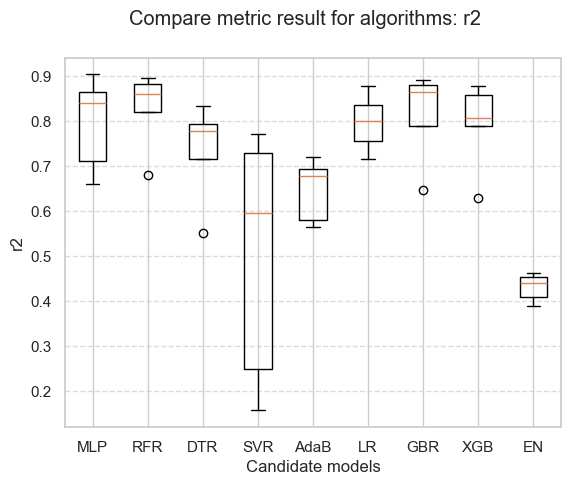

####### Evaluation metric:  neg_root_mean_squared_error

Training model: MLP with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: MLP, neg_root_mean_squared_error Mean: -61.5993, Std: 18.0487


Training model: RFR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: RFR, neg_root_mean_squared_error Mean: -56.7323, Std: 15.2033


Training model: DTR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: DTR, neg_root_mean_squared_error Mean: -67.8407, Std: 12.0925


Training model: SVR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: SVR, neg_root_mean_squared_error Mean: -96.6530, Std: 31.2366


Training model: AdaB with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: AdaB, neg_root_mean_squared_error Mean: -79.1053, Std: 6.7788


Training model: LR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 fol

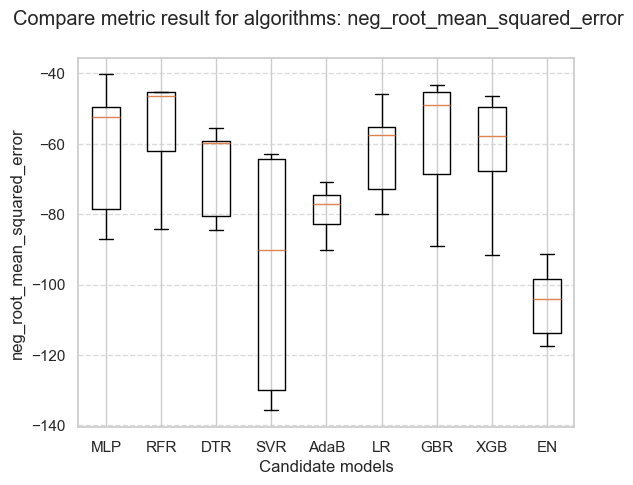

In [108]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warnings from sklearn (like ConvergenceWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Cross-validation training
for scoring in error_metrics:
    results = [] # store metrics results
    msg = []  # print summary of result
    names = []  # store name of the models
    print('####### Evaluation metric: ', scoring)
    
    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation = TimeSeriesSplit(n_splits=num_folds)
        
        # Start the cross-validation process and print verbose output
        print(f"Performing TimeSeriesSplit with {num_folds} folds...")
        
        cv_results = cross_val_score(model, X_train_scaled, y_train, cv=cross_validation, scoring=scoring)
        
        print(f"Model: {name}, {scoring} Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}\n")

        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    

    # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 7. Best Model Hyperparameters Adjustment
    
</div>

> Steps to perform the hyperadjustment of the parameters:
> * Specify the model to be adjusted
> * Specify a metric to optimize
> * Define the search hyperparameter ranges: *params*
> * Assign a validation method: *KFold*
> * Find the Hyperparameters with the validation data: *X_val*



In [110]:
model = RandomForestRegressor()
scoring= 'r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
     # Maximum number of levels in tree
   #  'max_depth': [2, None],  #deafult = None
     # Method of selecting samples for training each tree
}


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val_scaled)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val_scaled, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..................n_estimators=100;, score=0.927 total time=   0.2s
[CV 2/5] END .................n_estimators=100;, score=-1.183 total time=   0.5s
[CV 3/5] END ..................n_estimators=100;, score=0.377 total time=   0.6s
[CV 4/5] END ..................n_estimators=100;, score=0.208 total time=   0.9s
[CV 5/5] END ..................n_estimators=100;, score=0.297 total time=   1.1s
[CV 1/5] END ..................n_estimators=500;, score=0.926 total time=   1.6s
[CV 2/5] END .................n_estimators=500;, score=-1.279 total time=   3.6s
[CV 3/5] END ..................n_estimators=500;, score=0.374 total time=   3.6s
[CV 4/5] END ..................n_estimators=500;, score=0.216 total time=   4.7s
[CV 5/5] END ..................n_estimators=500;, score=0.293 total time=   4.0s
Best result: 0.125145 using the following hyperparameters {'n_estimators': 100}





<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 8. Final evaluation of the model
    
</div>

> * Finally, the model is built.
> *     
The ``fit()`` model is trained with the optimal hyperparameters found in the previous section and then the predictions are made. 
> * Use the ``X_test`` data to make the predictions



In [112]:
final_model_v1 = RandomForestRegressor(n_estimators=500, max_depth=None) ## train again with the winner model from the Grid Search
final_model_v1.fit(X_train_scaled,y_train)  # Model training 
y_predict_v1 = final_model_v1.predict(X_test_scaled)  # prediction calculation




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


Calculate the Evaluation Metrics for this final model
    
</div>


In [114]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² (R-squared) score
r2 = r2_score(y_test, y_predict_v1)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_predict_v1, squared=False)

# Print both the R² and RMSE scores
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.8616
RMSE: 45.8605




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


Plot the predictions ``y_predict`` vs the real values ``y_test``
    
</div>


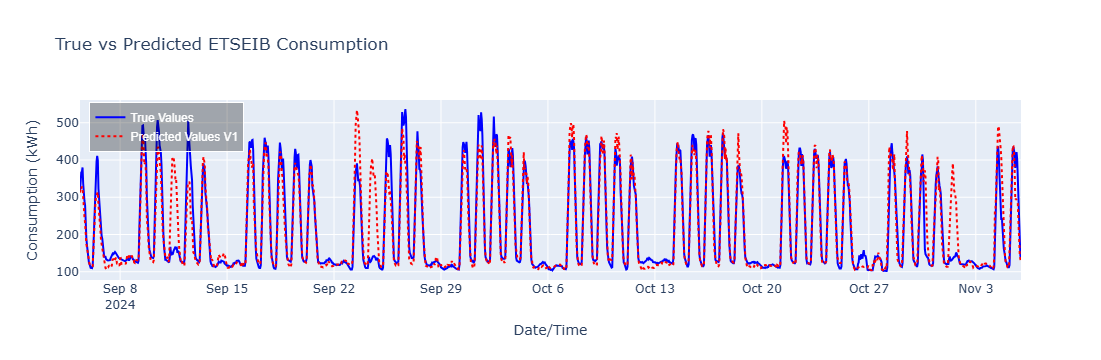

In [116]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the trace for the actual consumption (True Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='True Values',
                         line=dict(color='blue', width=2)))

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v1, mode='lines', name='Predicted Values V1',
                         line=dict(color='red', width=2, dash='dot')))  # 'dot' for less separated dashes


# Update layout for a more beautiful plot
fig.update_layout(
    title='True vs Predicted ETSEIB Consumption',
    xaxis_title='Date/Time',
    yaxis_title='Consumption (kWh)',
    template='plotly',  # dark theme, can change to 'plotly' for light theme
    hovermode='x unified',  # hover over to show values for both lines at a time
    legend=dict(
        x=0.01, y=0.99,  # position of legend
        traceorder='normal',
        font=dict(family="Arial", size=12, color="white"),
        bgcolor='rgba(0, 0, 0, 0.3)',
        bordercolor='white',
        borderwidth=1
    ),
   
   
)

# Show the plot
fig.show()



<div class="alert alert-success">
     <b>  </b>
  
## What happens to the model? Can we improve it? How? 

</div>



---

<div style="background-color: #ffffe0; padding: 15px; border-radius: 5px;">

# **Let's build a SECOND model!** 
    
    ``model_v2``

</div>

> * We will use the Holidays library to identify holidays in Catalonia.
> * Thus, a new input feature will be created.


---


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Use the library Holidays
    
</div>

In [124]:
import holidays  # https://pypi.org/project/holidays/


# Use the 'holidays' library to get public holidays in Spain for both 2023 and 2024
es_holidays_2023 = holidays.Spain(years=2023, prov='CT')  # Catalonia
es_holidays_2024 = holidays.Spain(years=2024, prov='CT')  # Catalonia

# Combine both holidays (2023 and 2024) into one set
all_holidays = {**es_holidays_2023, **es_holidays_2024}

all_holidays

{datetime.date(2023, 1, 6): 'Epifanía del Señor',
 datetime.date(2023, 4, 7): 'Viernes Santo',
 datetime.date(2023, 5, 1): 'Fiesta del Trabajo',
 datetime.date(2023, 8, 15): 'Asunción de la Virgen',
 datetime.date(2023, 10, 12): 'Fiesta Nacional de España',
 datetime.date(2023, 11, 1): 'Todos los Santos',
 datetime.date(2023, 12, 6): 'Día de la Constitución Española',
 datetime.date(2023, 12, 8): 'Inmaculada Concepción',
 datetime.date(2023, 12, 25): 'Natividad del Señor',
 datetime.date(2023, 4, 10): 'Lunes de Pascua',
 datetime.date(2023, 6, 24): 'San Juan',
 datetime.date(2023, 9, 11): 'Fiesta Nacional de Cataluña',
 datetime.date(2023, 12, 26): 'San Esteban',
 datetime.date(2024, 1, 1): 'Año nuevo',
 datetime.date(2024, 1, 6): 'Epifanía del Señor',
 datetime.date(2024, 3, 29): 'Viernes Santo',
 datetime.date(2024, 5, 1): 'Fiesta del Trabajo',
 datetime.date(2024, 8, 15): 'Asunción de la Virgen',
 datetime.date(2024, 10, 12): 'Fiesta Nacional de España',
 datetime.date(2024, 11, 1):


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Create a second version of the dataset  ``dataset_v2``
    
</div>

In [127]:
dataset_v2 = dataset.copy()

# Check if the Datetime column dates are in 'all_holidays'
dataset_v2['is_holiday'] = dataset_v2["Datetime"].dt.date.isin(all_holidays.keys()).astype(int)

In [129]:
dataset_v2

Datetime  ETSEIB_consumption  month  is_weekend  \
504   2023-09-22 00:00:00                 113      9           0   
505   2023-09-22 01:00:00                 113      9           0   
506   2023-09-22 02:00:00                 112      9           0   
507   2023-09-22 03:00:00                 105      9           0   
508   2023-09-22 04:00:00                 103      9           0   
...                   ...                 ...    ...         ...   
10364 2024-11-05 19:00:00                 282     11           0   
10365 2024-11-05 20:00:00                 217     11           0   
10366 2024-11-05 21:00:00                 168     11           0   
10367 2024-11-05 22:00:00                 143     11           0   
10368 2024-11-05 23:00:00                 134     11           0   

       day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
504              0.0            0.0            0.0            0.0   
505              0.0            0.0            0.0            0.0   
506              0.0            0.0            0.0            0.0   
507              0.0            0.0            0.0            0.0   
508              0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
10364            0.0            1.0            0.0            0.0   
10365            0.0            1.0            0.0            0.0   
10366            0.0            1.0            0.0            0.0   
10367            0.0            1.0            0.0            0.0   
10368            0.0            1.0            0.0            0.0   

       day_of_week_4  day_of_week_5  ...  hour_20  hour_21  hour_22  hour_23  \
504              1.0            0.0  ...      0.0      0.0      0.0      0.0   
505              1.0            0.0  ...      0.0      0.0      0.0      0.0   
506              1.0            0.0  ...      0.0      0.0      0.0      0.0   
507              1.0            0.0  ...      0.0      0.0      0.0      0.0   
508              1.0            0.0  ...      0.0      0.0      0.0      0.0   
...              ...            ...  ...      ...      ...      ...      ...   
10364            0.0            0.0  ...      0.0      0.0      0.0      0.0   
10365            0.0            0.0  ...      1.0      0.0      0.0      0.0   
10366            0.0            0.0  ...      0.0      1.0      0.0      0.0   
10367            0.0            0.0  ...      0.0      0.0      1.0      0.0   
10368            0.0            0.0  ...      0.0      0.0      0.0      1.0   

       Lag_1_day  Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  is_holiday  
504        117.0       118.0       123.0        120.0        100.0           0  
505        118.0       115.0       121.0        112.0         98.0           0  
506        115.0       110.0       116.0        111.0         97.0           0  
507        108.0       105.0       110.0        110.0         96.0           0  
508        107.0       105.0       108.0        107.0         96.0           0  
...          ...         ...         ...          ...          ...         ...  
10364      176.0       114.0       249.0        213.0        216.0           0  
10365      162.0       113.0       194.0        160.0        171.0           0  
10366      152.0       111.0       156.0        133.0        144.0           0  
10367      133.0       110.0       132.0        123.0        132.0           0  
10368      127.0       111.0       128.0        124.0        126.0           0  

[9864 rows x 41 columns]


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px;font-weight: bold; margin-top: 25px;">

Plot the correlation matrix again
    
</div>

> A correlation matrix is a table that shows the pairwise correlation coefficients between a set of variables (or features) in a dataset. Each element in the matrix represents the correlation between two features.

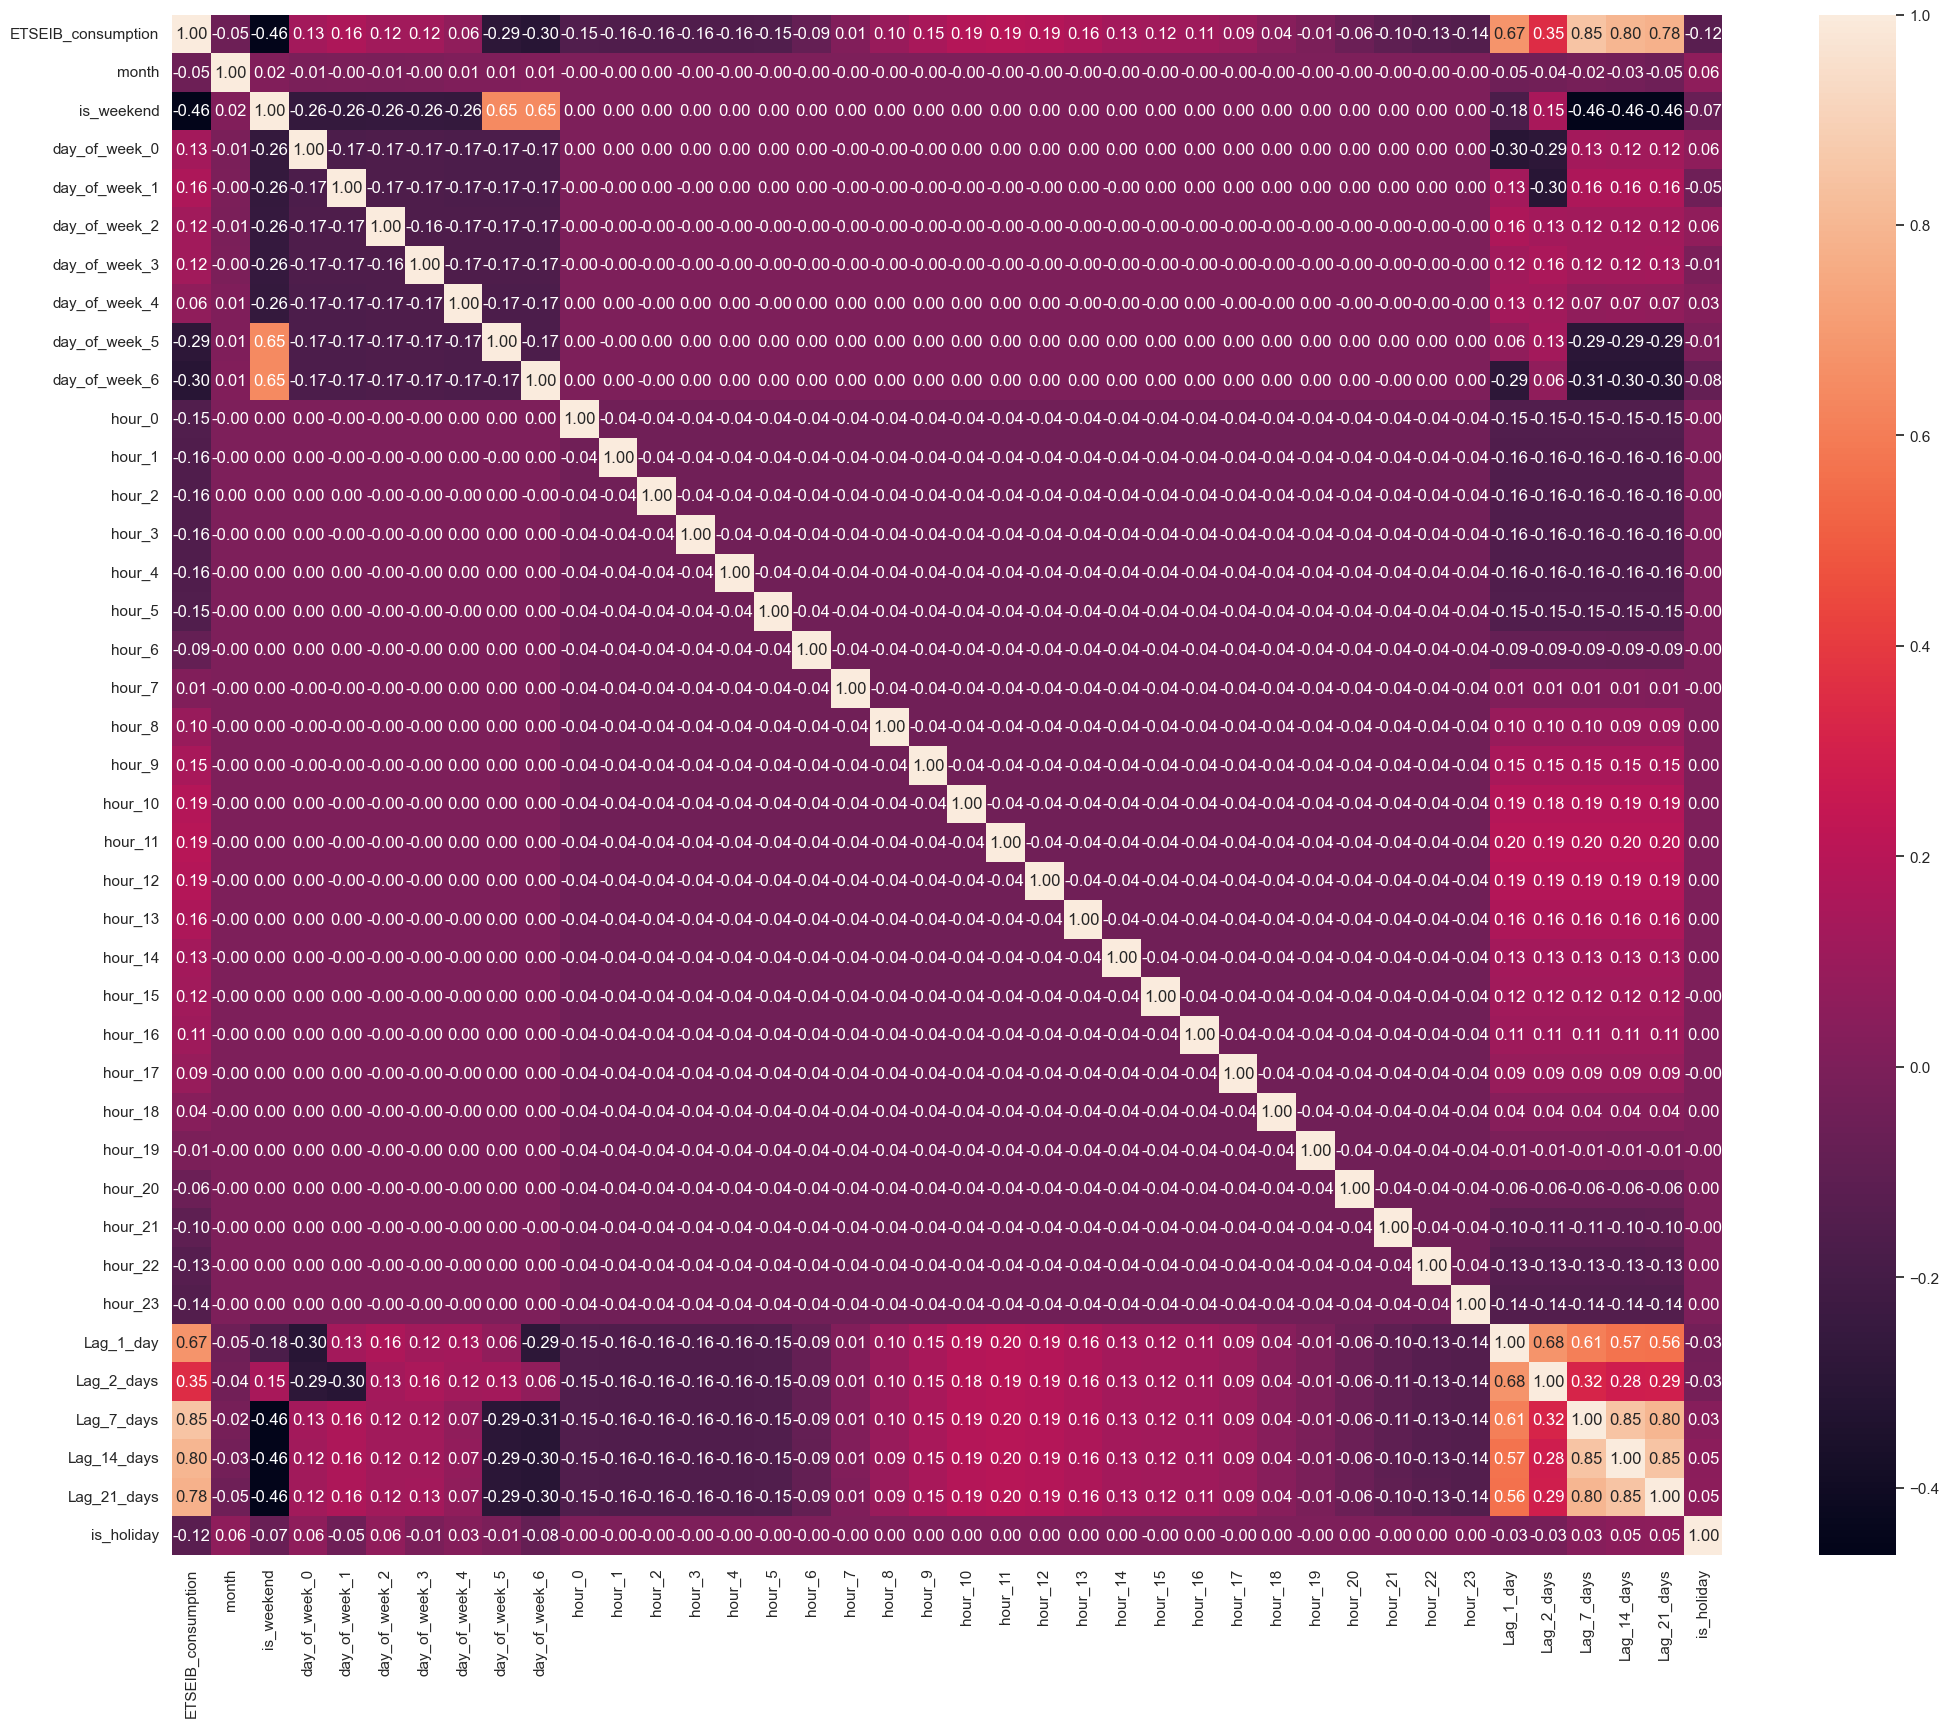

In [131]:
### Seaborn visualization library
import seaborn as sns

# Calculate the correlation matrix
corr = dataset_v2.iloc[:,1:].corr(method='pearson') 

# Plot Heat Map,
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [133]:
# Set the datetime column as index
dataset_v2 = dataset_v2.set_index('Datetime')





<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 4. Split the data
    
</div>

> * Divide the data into attributes: X (features) and tags: y (target).
> * Scale the data


In [136]:
# Features X ; Target y 
X = dataset_v2.drop(['ETSEIB_consumption'], axis=1) 
y = dataset_v2['ETSEIB_consumption']


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


The data are divided into training data ``X_train``, ``y_train``, validation data ``X_val``, ``y_val`` and test data ``X_test``, ``y_test``.
</div>



In [139]:
from sklearn.model_selection import train_test_split

test_size = 0.15  # percentage of the input data that I will use to validate the model

# I divide the data into training, validation and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Let's scale the dataset
    
</div>


The data is scaled using the ``MinMaxScaler()`` method, which scales and translates each attribute individually such that it is within the range [0, 1]. This needs to be done when the scales of the attributes are different (e.g. radiation [0, 650], wind speed [2, 15]).


* ``MinMaxScaler()``: This scaler will normalize the values of the features to be within a specific range, typically [0, 1]. It does this by subtracting the minimum value and dividing by the range (max - min).
* ``fit_transform(X_train)``: This step calculates the Min and Max values from the X_train data and applies the scaling transformation.
* ``transform(X_val) and transform(X_test)``: These steps scale the validation and test sets using the same scaling parameters (Min and Max) derived from the training set, ensuring that data leakage doesn't occur.

In [144]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_v2 = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler_v2.fit_transform(X_train)

# Use the same scaler to transform the validation and test data (do not fit again)
X_val_scaled = scaler_v2.transform(X_val)
X_test_scaled = scaler_v2.transform(X_test)




Now, X_train_scaled, X_val_scaled, X_test_scaled are scaled versions of the original datasets.


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 6. Model building and evaluation
    
</div>


In [148]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor


# Define the number of folds and error metrics
num_folds =3
error_metrics = {'neg_root_mean_squared_error', 'r2'}


# Define a dictionary with models
models = {
    ('MLP', MLPRegressor()),
    ('RFR', RandomForestRegressor()),
    ('SVR', SVR()),
    ('AdaB', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),  # Gradient Boosting Regressor
    ('DTR', DecisionTreeRegressor()),  # Decision Tree Regressor
    ('XGB', XGBRegressor()),  # XGBoost Regressor
    ('LR', LinearRegression()),  # Linear Regression
    ('EN', ElasticNet())  # ElasticNet Regressor
}




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">



Each of the models is trained, the results are saved and compared visually.
    
</div>


####### Evaluation metric:  r2

Training model: SVR with r2...
Performing TimeSeriesSplit with 3 folds...
Model: SVR, r2 Mean: 0.5376, Std: 0.2247


Training model: DTR with r2...
Performing TimeSeriesSplit with 3 folds...
Model: DTR, r2 Mean: 0.8182, Std: 0.0750


Training model: GBR with r2...
Performing TimeSeriesSplit with 3 folds...
Model: GBR, r2 Mean: 0.8183, Std: 0.1486


Training model: MLP with r2...
Performing TimeSeriesSplit with 3 folds...
Model: MLP, r2 Mean: 0.8351, Std: 0.1032


Training model: RFR with r2...
Performing TimeSeriesSplit with 3 folds...
Model: RFR, r2 Mean: 0.8354, Std: 0.1121


Training model: AdaB with r2...
Performing TimeSeriesSplit with 3 folds...
Model: AdaB, r2 Mean: 0.7120, Std: 0.0682


Training model: LR with r2...
Performing TimeSeriesSplit with 3 folds...
Model: LR, r2 Mean: 0.7261, Std: 0.2019


Training model: XGB with r2...
Performing TimeSeriesSplit with 3 folds...
Model: XGB, r2 Mean: 0.8319, Std: 0.1216


Training model: EN with r2...
Pe

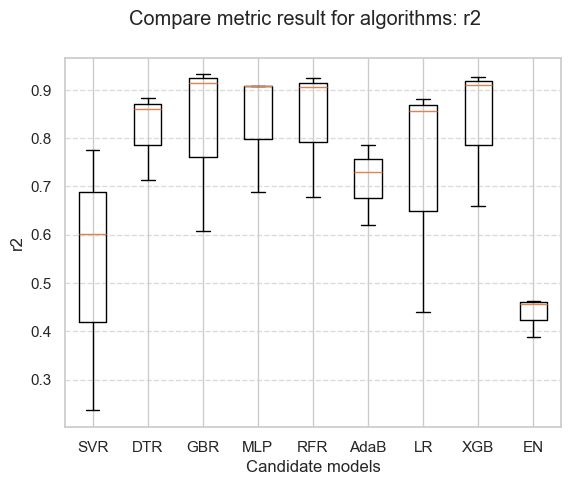

####### Evaluation metric:  neg_root_mean_squared_error

Training model: SVR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 folds...
Model: SVR, neg_root_mean_squared_error Mean: -93.3442, Std: 29.5913


Training model: DTR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 folds...
Model: DTR, neg_root_mean_squared_error Mean: -60.4679, Std: 15.9439


Training model: GBR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 folds...
Model: GBR, neg_root_mean_squared_error Mean: -56.2449, Std: 27.6302


Training model: MLP with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 folds...
Model: MLP, neg_root_mean_squared_error Mean: -54.9640, Std: 20.7837


Training model: RFR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 folds...
Model: RFR, neg_root_mean_squared_error Mean: -54.2069, Std: 21.6016


Training model: AdaB with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 3 fo

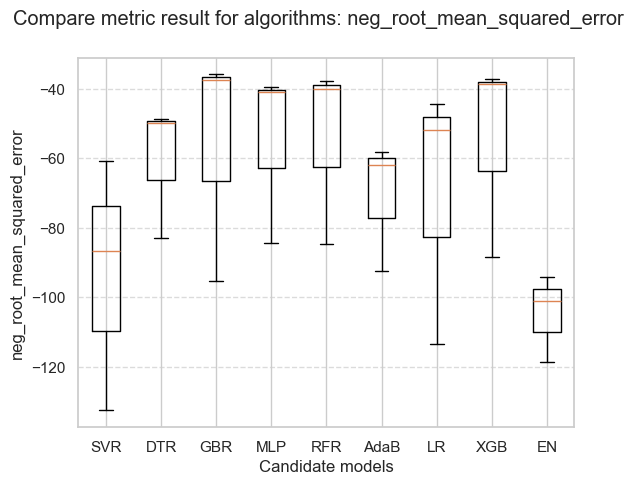

In [151]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warnings from sklearn (like ConvergenceWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Cross-validation training
for scoring in error_metrics:
    results = [] # store metrics results
    msg = []  # print summary of result
    names = []  # store name of the models
    print('####### Evaluation metric: ', scoring)
    
    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation = TimeSeriesSplit(n_splits=num_folds)
        
        # Start the cross-validation process and print verbose output
        print(f"Performing TimeSeriesSplit with {num_folds} folds...")
        
        cv_results = cross_val_score(model, X_train_scaled, y_train, cv=cross_validation, scoring=scoring)
        
        print(f"Model: {name}, {scoring} Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}\n")

        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    

    # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 7. Best Model Hyperparameters Adjustment
    
</div>

> Steps to perform the hyperadjustment of the parameters:
> * Specify the model to be adjusted
> * Specify a metric to optimize
> * Define the search hyperparameter ranges: *params*
> * Assign a validation method: *KFold*
> * Find the Hyperparameters with the validation data: *X_val*



In [153]:
model = RandomForestRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
     # Maximum number of levels in tree
    'max_depth': [2, None],  #deafult = None
     # Method of selecting samples for training each tree
}


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val_scaled)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val_scaled, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.896 total time=   0.1s
[CV 2/5] END ....max_depth=2, n_estimators=100;, score=-3.113 total time=   0.1s
[CV 3/5] END ....max_depth=2, n_estimators=100;, score=-0.137 total time=   0.2s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.000 total time=   0.2s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.141 total time=   0.3s
[CV 1/5] END .....max_depth=2, n_estimators=500;, score=0.897 total time=   1.3s
[CV 2/5] END ....max_depth=2, n_estimators=500;, score=-3.143 total time=   2.3s
[CV 3/5] END ....max_depth=2, n_estimators=500;, score=-0.168 total time=   1.3s
[CV 4/5] END ....max_depth=2, n_estimators=500;, score=-0.000 total time=   1.4s
[CV 5/5] END .....max_depth=2, n_estimators=500;, score=0.129 total time=   1.5s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.917 total time=   0.2s
[CV 2/5] END .max_depth=None, n_estimators=100;, 




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 8. Final evaluation of the model
    
</div>

> * Finally, the model is built.
> *     
The ``fit()`` model is trained with the optimal hyperparameters found in the previous section and then the predictions are made. 
> * Use the ``X_test`` data to make the predictions



In [156]:
final_model_v2 = RandomForestRegressor(n_estimators=500, max_depth=None) ## train again with the winner model from the Grid Search
final_model_v2.fit(X_train_scaled,y_train)  # Model training 
y_predict_v2 = final_model_v2.predict(X_test_scaled)  # prediction calculation




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


Calculate the Evaluation Metrics for this final model
    
</div>


In [158]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² (R-squared) score
r2 = r2_score(y_test, y_predict_v2)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_predict_v2, squared=False)

# Print both the R² and RMSE scores
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.9017
RMSE: 38.6509




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


Plot the predictions ``y_predict`` vs the real values ``y_test``
    
</div>


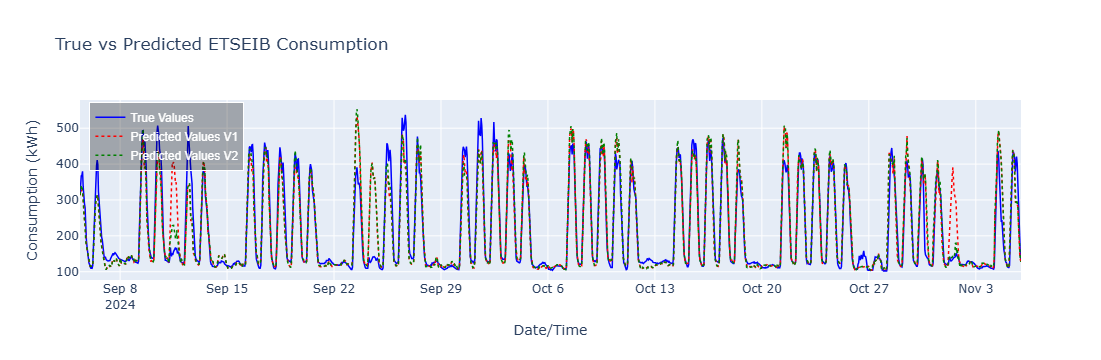

In [160]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the trace for the actual consumption (True Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='True Values',
                         line=dict(color='blue', width=1.5)))

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v1, mode='lines', name='Predicted Values V1',
                         line=dict(color='red', width=1.5, dash='dot')))  # 'dot' for less separated dashes


# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v2, mode='lines', name='Predicted Values V2',
                         line=dict(color='green', width=1.5, dash='dot')))  # 'dot' for less separated dashes


# Update layout for a more beautiful plot
fig.update_layout(
    title='True vs Predicted ETSEIB Consumption',
    xaxis_title='Date/Time',
    yaxis_title='Consumption (kWh)',
    template='plotly',  # dark theme, can change to 'plotly' for light theme
    hovermode='x unified',  # hover over to show values for both lines at a time
    legend=dict(
        x=0.01, y=0.99,  # position of legend
        traceorder='normal',
        font=dict(family="Arial", size=12, color="white"),
        bgcolor='rgba(0, 0, 0, 0.3)',
        bordercolor='white',
        borderwidth=1
    ),
   
   
)

# Show the plot
fig.show()

---

<div style="background-color: #ffffe0; padding: 15px; border-radius: 5px;">

# **Let's build a THIRD model!** 
    
    ``model_v3``

</div>

> * We will use the Holidays library to identify holidays in Catalonia.
> * Thus, a new input feature will be created.


---





<div class="alert alert-success">
     <b>  </b>
  

### Let's keep improving

* Let's build a 3th version of our model. 
* Para acortar los procesos, asumiremos que el mejor modelo es RF, y no testearemos todos los disponibles.
    
    
</div>


In [166]:

# As a starting point...
dataset_v3 = dataset_v2.copy()
dataset_v3

ETSEIB_consumption  month  is_weekend  day_of_week_0  \
Datetime                                                                    
2023-09-22 00:00:00                 113      9           0            0.0   
2023-09-22 01:00:00                 113      9           0            0.0   
2023-09-22 02:00:00                 112      9           0            0.0   
2023-09-22 03:00:00                 105      9           0            0.0   
2023-09-22 04:00:00                 103      9           0            0.0   
...                                 ...    ...         ...            ...   
2024-11-05 19:00:00                 282     11           0            0.0   
2024-11-05 20:00:00                 217     11           0            0.0   
2024-11-05 21:00:00                 168     11           0            0.0   
2024-11-05 22:00:00                 143     11           0            0.0   
2024-11-05 23:00:00                 134     11           0            0.0   

                     day_of_week_1  day_of_week_2  day_of_week_3  \
Datetime                                                           
2023-09-22 00:00:00            0.0            0.0            0.0   
2023-09-22 01:00:00            0.0            0.0            0.0   
2023-09-22 02:00:00            0.0            0.0            0.0   
2023-09-22 03:00:00            0.0            0.0            0.0   
2023-09-22 04:00:00            0.0            0.0            0.0   
...                            ...            ...            ...   
2024-11-05 19:00:00            1.0            0.0            0.0   
2024-11-05 20:00:00            1.0            0.0            0.0   
2024-11-05 21:00:00            1.0            0.0            0.0   
2024-11-05 22:00:00            1.0            0.0            0.0   
2024-11-05 23:00:00            1.0            0.0            0.0   

                     day_of_week_4  day_of_week_5  day_of_week_6  ...  \
Datetime                                                          ...   
2023-09-22 00:00:00            1.0            0.0            0.0  ...   
2023-09-22 01:00:00            1.0            0.0            0.0  ...   
2023-09-22 02:00:00            1.0            0.0            0.0  ...   
2023-09-22 03:00:00            1.0            0.0            0.0  ...   
2023-09-22 04:00:00            1.0            0.0            0.0  ...   
...                            ...            ...            ...  ...   
2024-11-05 19:00:00            0.0            0.0            0.0  ...   
2024-11-05 20:00:00            0.0            0.0            0.0  ...   
2024-11-05 21:00:00            0.0            0.0            0.0  ...   
2024-11-05 22:00:00            0.0            0.0            0.0  ...   
2024-11-05 23:00:00            0.0            0.0            0.0  ...   

                     hour_20  hour_21  hour_22  hour_23  Lag_1_day  \
Datetime                                                             
2023-09-22 00:00:00      0.0      0.0      0.0      0.0      117.0   
2023-09-22 01:00:00      0.0      0.0      0.0      0.0      118.0   
2023-09-22 02:00:00      0.0      0.0      0.0      0.0      115.0   
2023-09-22 03:00:00      0.0      0.0      0.0      0.0      108.0   
2023-09-22 04:00:00      0.0      0.0      0.0      0.0      107.0   
...                      ...      ...      ...      ...        ...   
2024-11-05 19:00:00      0.0      0.0      0.0      0.0      176.0   
2024-11-05 20:00:00      1.0      0.0      0.0      0.0      162.0   
2024-11-05 21:00:00      0.0      1.0      0.0      0.0      152.0   
2024-11-05 22:00:00      0.0      0.0      1.0      0.0      133.0   
2024-11-05 23:00:00      0.0      0.0      0.0      1.0      127.0   

                     Lag_2_days  Lag_7_days  Lag_14_days  Lag_21_days  \
Datetime                                                                
2023-09-22 00:00:00       118.0       123.0        120.0        100.0   
2023-09-22 01:00:00       115.0       121.0        112




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 4. Split the data
    
</div>

> * Divide the data into attributes: X (features) and tags: y (target).
> * Scale the data


### Split the data into Attributes and Target

I divide the data into **attributes**: X (features) and **tags**: y (target).

In [172]:
# Features X ; Target y 
X = dataset_v3.drop(['ETSEIB_consumption'], axis=1) 
y = dataset_v3['ETSEIB_consumption']


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">


The data are divided into training data ``X_train``, ``y_train``, validation data ``X_val``, ``y_val`` and test data ``X_test``, ``y_test``.
</div>



In [175]:
from sklearn.model_selection import train_test_split

test_size = 0.15  # percentage of the input data that I will use to validate the model

# I divide the data into training, validation and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)

Let's scale the dataset

The data is scaled using the ``MinMaxScaler()`` method, which scales and translates each attribute individually such that it is within the range [0, 1]. This needs to be done when the scales of the attributes are different (e.g. radiation [0, 650], wind speed [2, 15]).


* ``MinMaxScaler()``: This scaler will normalize the values of the features to be within a specific range, typically [0, 1]. It does this by subtracting the minimum value and dividing by the range (max - min).
* ``fit_transform(X_train)``: This step calculates the Min and Max values from the X_train data and applies the scaling transformation.
* ``transform(X_val) and transform(X_test)``: These steps scale the validation and test sets using the same scaling parameters (Min and Max) derived from the training set, ensuring that data leakage doesn't occur.

In [180]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_v3 = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler_v3.fit_transform(X_train)

# Use the same scaler to transform the validation and test data (do not fit again)
X_val_scaled = scaler_v3.transform(X_val)
X_test_scaled = scaler_v3.transform(X_test)




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

Recursive Featuring Elimination
    
</div>

> * Recursive Feature Engineering (often referred to as Recursive Feature Elimination, or RFE) in scikit-learn is a method used to select important features for a machine learning model by recursively removing less important ones. It works by training the model multiple times, each time eliminating the least important feature(s) based on model performance, until the desired number of features is reached.
> * <img src="Figures/wrapper-method.png" alt="Drawing" style="width: 800px;"/>


In [184]:
from sklearn.feature_selection import RFE


# Initialize Recursive Feature Elimination with the model and specify the number of features to select
n_features_to_select = 37  # Adjust as needed

# Initialize the model
model_rfe = RandomForestRegressor(n_estimators=500, random_state=42)
rfe = RFE(estimator=model_rfe, n_features_to_select=n_features_to_select, verbose=3)

# Fit RFE on the training data
rfe.fit(X_train_scaled, y_train) 


# Get the mask of selected features
selected_features_mask = rfe.support_
selected_features = X.columns[selected_features_mask]  # List the selected feature names
deleted_features = X.columns[~selected_features_mask]

print("Selected features:", selected_features)
print("Deleted features:", deleted_features)

# Filter the original DataFrame to include only the selected features
X_selected = X[selected_features]
X_selected

Fitting estimator with 39 features.
Fitting estimator with 38 features.
Selected features: Index(['month', 'is_weekend', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_0', 'hour_1', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Lag_1_day',
       'Lag_2_days', 'Lag_7_days', 'Lag_14_days', 'Lag_21_days', 'is_holiday'],
      dtype='object')
Deleted features: Index(['hour_2', 'hour_3'], dtype='object')


month  is_weekend  day_of_week_0  day_of_week_1  \
Datetime                                                               
2023-09-22 00:00:00      9           0            0.0            0.0   
2023-09-22 01:00:00      9           0            0.0            0.0   
2023-09-22 02:00:00      9           0            0.0            0.0   
2023-09-22 03:00:00      9           0            0.0            0.0   
2023-09-22 04:00:00      9           0            0.0            0.0   
...                    ...         ...            ...            ...   
2024-11-05 19:00:00     11           0            0.0            1.0   
2024-11-05 20:00:00     11           0            0.0            1.0   
2024-11-05 21:00:00     11           0            0.0            1.0   
2024-11-05 22:00:00     11           0            0.0            1.0   
2024-11-05 23:00:00     11           0            0.0            1.0   

                     day_of_week_2  day_of_week_3  day_of_week_4  \
Datetime                                                           
2023-09-22 00:00:00            0.0            0.0            1.0   
2023-09-22 01:00:00            0.0            0.0            1.0   
2023-09-22 02:00:00            0.0            0.0            1.0   
2023-09-22 03:00:00            0.0            0.0            1.0   
2023-09-22 04:00:00            0.0            0.0            1.0   
...                            ...            ...            ...   
2024-11-05 19:00:00            0.0            0.0            0.0   
2024-11-05 20:00:00            0.0            0.0            0.0   
2024-11-05 21:00:00            0.0            0.0            0.0   
2024-11-05 22:00:00            0.0            0.0            0.0   
2024-11-05 23:00:00            0.0            0.0            0.0   

                     day_of_week_5  day_of_week_6  hour_0  ...  hour_20  \
Datetime                                                   ...            
2023-09-22 00:00:00            0.0            0.0     1.0  ...      0.0   
2023-09-22 01:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 02:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 03:00:00            0.0            0.0     0.0  ...      0.0   
2023-09-22 04:00:00            0.0            0.0     0.0  ...      0.0   
...                            ...            ...     ...  ...      ...   
2024-11-05 19:00:00            0.0            0.0     0.0  ...      0.0   
2024-11-05 20:00:00            0.0            0.0     0.0  ...      1.0   
2024-11-05 21:00:00            0.0            0.0     0.0  ...      0.0   
2024-11-05 22:00:00            0.0            0.0     0.0  ...      0.0   
2024-11-05 23:00:00            0.0            0.0     0.0  ...      0.0   

                     hour_21  hour_22  hour_23  Lag_1_day  Lag_2_days  \
Datetime                                                                
2023-09-22 00:00:00      0.0      0.0      0.0      117.0       118.0   
2023-09-22 01:00:00      0.0      0.0      0.0      118.0       115.0   
2023-09-22 02:00:00      0.0      0.0      0.0      115.0       110.0   
2023-09-22 03:00:00      0.0      0.0      0.0      108.0       105.0   
2023-09-22 04:00:00      0.0      0.0      0.0      107.0       105.0   
...                      ...      ...      ...        ...         ...   
2024-11-05 19:00:00      0.0      0.0      0.0      176.0       114.0   
2024-11-05 20:00:00      0.0      0.0      0.0      162.0       113.0   
2024-11-05 21:00:00      1.0      0.0      0.0      152.0       111.0   
2024-11-05 22:00:00      0.0      1.0      0.0      133.0       110.0   
2024-11-05 23:00:00      0.0      0.0      1.0      127.0       111.0   

                     Lag_7_days  Lag_14_days  Lag_21_days  is_holiday  
Datetime                                                               
2023-09-22 00:00:00       123.0        120.0        100.0           0  
2023-09-22 01:00:00       121.0        112.0         98.0



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

Print the selected and deleted features
    
</div>


In [186]:

selected_features = X.columns[selected_features_mask]  # List the selected feature names
deleted_features = X.columns[~selected_features_mask]

print("Selected features:", selected_features)
print("Deleted features:", deleted_features)


Selected features: Index(['month', 'is_weekend', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_0', 'hour_1', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Lag_1_day',
       'Lag_2_days', 'Lag_7_days', 'Lag_14_days', 'Lag_21_days', 'is_holiday'],
      dtype='object')
Deleted features: Index(['hour_2', 'hour_3'], dtype='object')


In [190]:
# 4. Transform the train, validation, and test sets to include only the selected features
from sklearn.model_selection import train_test_split

test_size = 0.15  # percentage of the input data that I will use to validate the model

# I divide the data into training, validation and test data.
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=test_size,
                                                    shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)


from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled_selected = scaler.fit_transform(X_train)

# Use the same scaler to transform the validation and test data (do not fit again)
X_val_scaled_selected = scaler.transform(X_val)
X_test_scaled_selected = scaler.transform(X_test)

In [192]:

# selected_features_25 = ['month', 'is_weekend', 'day_of_week_0', 'day_of_week_1',
#        'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
#        'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_12', 'hour_13',
#        'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'Lag_1_day',
#        'Lag_2_days', 'Lag_7_days', 'Lag_14_days', 'Lag_21_days', 'is_holiday']


# selected_features_37 = ['month', 'is_weekend', 'day_of_week_0', 'day_of_week_1',
#        'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
#        'day_of_week_6', 'hour_0', 'hour_1', 'hour_4', 'hour_5', 'hour_6',
#        'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
#        'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
#        'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Lag_1_day',
#        'Lag_2_days', 'Lag_7_days', 'Lag_14_days', 'Lag_21_days', 'is_holiday']


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 6. Model building and evaluation
    
</div>


In [195]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor


# Define the number of folds and error metrics
num_folds = 5
error_metrics = {'neg_root_mean_squared_error', 'r2'}


# Define a dictionary with models
models = {
    ('MLP', MLPRegressor()),
    ('RFR', RandomForestRegressor()),
    ('AdaB', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),  # Gradient Boosting Regressor
    ('XGB', XGBRegressor()),  # XGBoost Regressor
}




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">



Each of the models is trained, the results are saved and compared visually.
    
</div>


####### Evaluation metric:  r2

Training model: GBR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: GBR, r2 Mean: 0.8661, Std: 0.0969


Training model: RFR with r2...
Performing TimeSeriesSplit with 5 folds...
Model: RFR, r2 Mean: 0.8761, Std: 0.0774


Training model: AdaB with r2...
Performing TimeSeriesSplit with 5 folds...
Model: AdaB, r2 Mean: 0.7710, Std: 0.0422


Training model: XGB with r2...
Performing TimeSeriesSplit with 5 folds...
Model: XGB, r2 Mean: 0.8746, Std: 0.0823


Training model: MLP with r2...
Performing TimeSeriesSplit with 5 folds...
Model: MLP, r2 Mean: 0.8333, Std: 0.1381



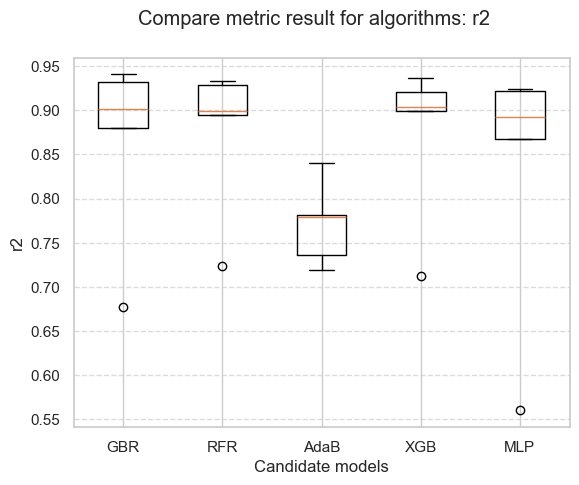

####### Evaluation metric:  neg_root_mean_squared_error

Training model: GBR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: GBR, neg_root_mean_squared_error Mean: -48.8850, Std: 19.2365


Training model: RFR with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: RFR, neg_root_mean_squared_error Mean: -47.4631, Std: 16.6792


Training model: AdaB with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: AdaB, neg_root_mean_squared_error Mean: -65.7509, Std: 9.3742


Training model: XGB with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: XGB, neg_root_mean_squared_error Mean: -47.6523, Std: 16.8287


Training model: MLP with neg_root_mean_squared_error...
Performing TimeSeriesSplit with 5 folds...
Model: MLP, neg_root_mean_squared_error Mean: -53.8194, Std: 24.1849



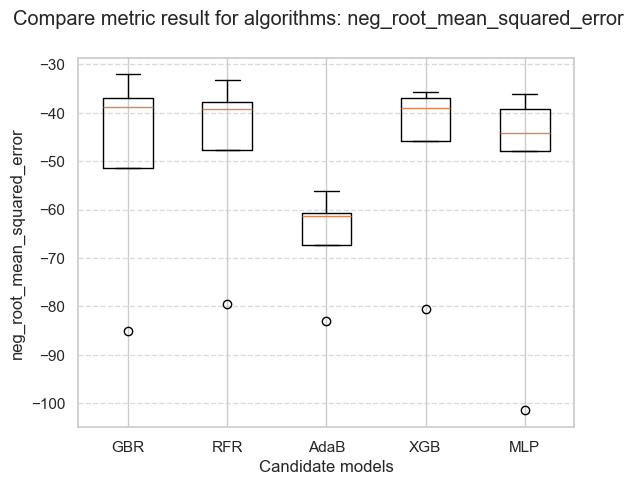

In [198]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warnings from sklearn (like ConvergenceWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Cross-validation training
for scoring in error_metrics:
    results = [] # store metrics results
    msg = []  # print summary of result
    names = []  # store name of the models
    print('####### Evaluation metric: ', scoring)
    
    for name, model in models:
        print(f'\nTraining model: {name} with {scoring}...')
        cross_validation = TimeSeriesSplit(n_splits=num_folds)
        
        # Start the cross-validation process and print verbose output
        print(f"Performing TimeSeriesSplit with {num_folds} folds...")
        
        cv_results = cross_val_score(model, X_train_scaled_selected, y_train, cv=cross_validation, scoring=scoring)
        
        print(f"Model: {name}, {scoring} Mean: {cv_results.mean():.4f}, Std: {cv_results.std():.4f}\n")

        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    

    # Compare results between algorithms
    fig = plt.figure()
    fig.suptitle('Compare metric result for algorithms: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Candidate models')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    # Show a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    results = []



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 7. Best Model Hyperparameters Adjustment
    
</div>

> Steps to perform the hyperadjustment of the parameters:
> * Specify the model to be adjusted
> * Specify a metric to optimize
> * Define the search hyperparameter ranges: *params*
> * Assign a validation method: *KFold*
> * Find the Hyperparameters with the validation data: *X_val*



In [200]:
model = RandomForestRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500],  # default=100
     # Maximum number of levels in tree
    'max_depth': [2, None],  #deafult = None
     # Method of selecting samples for training each tree
}


# Search for the best combination of hyperparameters
cross_validation = TimeSeriesSplit(n_splits=5)
my_cv = cross_validation.split(X_val_scaled_selected)
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=my_cv, verbose=3)
gsearch.fit(X_val_scaled_selected, y_val)

# Print best Result
print("Best result: %f using the following hyperparameters %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.893 total time=   0.1s
[CV 2/5] END ....max_depth=2, n_estimators=100;, score=-3.081 total time=   0.1s
[CV 3/5] END ....max_depth=2, n_estimators=100;, score=-0.171 total time=   0.1s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.000 total time=   0.2s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.116 total time=   0.1s
[CV 1/5] END .....max_depth=2, n_estimators=500;, score=0.894 total time=   0.6s
[CV 2/5] END ....max_depth=2, n_estimators=500;, score=-3.113 total time=   0.7s
[CV 3/5] END ....max_depth=2, n_estimators=500;, score=-0.167 total time=   0.8s
[CV 4/5] END .....max_depth=2, n_estimators=500;, score=0.000 total time=   0.8s
[CV 5/5] END .....max_depth=2, n_estimators=500;, score=0.124 total time=   1.2s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.924 total time=   0.3s
[CV 2/5] END .max_depth=None, n_estimators=100;, 




<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; font-weight: bold; margin-top: 25px;">

## 8. Final evaluation of the model
    
</div>

> * Finally, the model is built.
> *     
The ``fit()`` model is trained with the optimal hyperparameters found in the previous section and then the predictions are made. 
> * Use the ``X_test`` data to make the predictions



In [202]:
final_model_v3 = RandomForestRegressor(n_estimators=500, max_depth=None) ## train again with the winner model from the Grid Search
final_model_v3.fit(X_train_scaled_selected,y_train)  # Model training 
y_predict_v3 = final_model_v3.predict(X_test_scaled_selected)  # prediction calculation


In [203]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² (R-squared) score
r2 = r2_score(y_test, y_predict_v3)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_predict_v3, squared=False)

# Print both the R² and RMSE scores
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.9020
RMSE: 38.5936


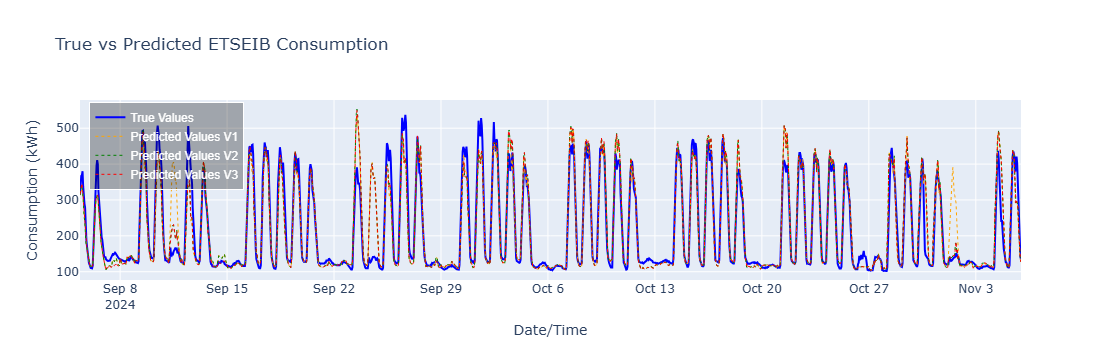

In [204]:
from sklearn.feature_selection import RFE


import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the trace for the actual consumption (True Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='True Values',
                         line=dict(color='blue', width=2)))

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v1, mode='lines', name='Predicted Values V1',
                         line=dict(color='orange', width=1, dash='dot')))  # 'dot' for less separated dashes

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v2, mode='lines', name='Predicted Values V2',
                         line=dict(color='green', width=1, dash='dot')))  # 'dot' for less separated dashes

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=y_test.index, y=y_predict_v3, mode='lines', name='Predicted Values V3',
                         line=dict(color='red', width=1, dash='dot')))  # 'dot' for less separated dashes


# Update layout for a more beautiful plot
fig.update_layout(
    title='True vs Predicted ETSEIB Consumption',
    xaxis_title='Date/Time',
    yaxis_title='Consumption (kWh)',
    template='plotly',  # dark theme, can change to 'plotly' for light theme
    hovermode='x unified',  # hover over to show values for both lines at a time
    legend=dict(
        x=0.01, y=0.99,  # position of legend
        traceorder='normal',
        font=dict(family="Arial", size=12, color="white"),
        bgcolor='rgba(0, 0, 0, 0.3)',
        bordercolor='white',
        borderwidth=1
    ),
   
   
)

# Show the plot
fig.show()

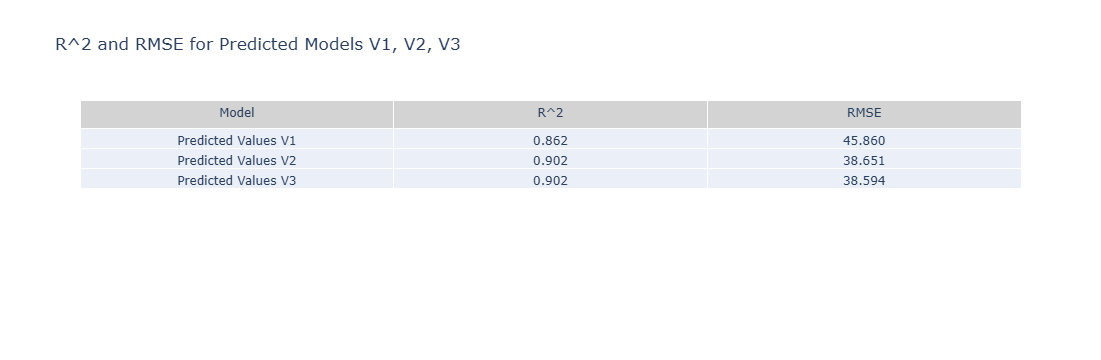

In [205]:

# Calculate R^2 and RMSE for each prediction version
metrics = {
    "Model": ["Predicted Values V1", "Predicted Values V2", "Predicted Values V3"],
    "R^2": [
        r2_score(y_test, y_predict_v1),
        r2_score(y_test, y_predict_v2),
        r2_score(y_test, y_predict_v3)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_predict_v1)),
        np.sqrt(mean_squared_error(y_test, y_predict_v2)),
        np.sqrt(mean_squared_error(y_test, y_predict_v3))
    ]
}

# Create the table with R^2 and RMSE values
table_fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "R^2", "RMSE"],
                fill_color='lightgrey',
                align='center'),
    cells=dict(values=[metrics["Model"], metrics["R^2"], metrics["RMSE"]],
               format=["", ".3f", ".3f"],  # formatting for R^2 and RMSE
               align='center')
)])

# Update layout for the table
table_fig.update_layout(title="R^2 and RMSE for Predicted Models V1, V2, V3")

# Show both plots
table_fig.show()   # Show the metrics table

---

<div style="background-color: #ffffe0; padding: 15px; border-radius: 5px;">

# **Store the model for production use**  
    

</div>

> * The **joblib library** in scikit-learn is a powerful tool for efficiently saving, loading, and handling large Python objects, particularly when working with machine learning models and large datasets. It is designed to optimize performance for models that require a lot of memory or computation time to train. Here’s how it’s commonly used:


---

In [211]:
import joblib

# Save the model
joblib.dump(final_model_v2, 'Data/etseib_modelv2.joblib')

# Save the scaler used for scaling the training data
joblib.dump(scaler_v2, 'Data/scaler_v2.joblib')

['Data/scaler_v2.joblib']



<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

The model is now saved for future use. When we need to make new predictions, we will load the model and provide it with the input data.
    
</div>

In [214]:
loaded_model = joblib.load('Data/etseib_modelv2.joblib') # Load the ML model
scaler_v2_loaded = joblib.load('Data/scaler_v2.joblib') # Load the saved scaler
print("Model loaded successfully!")

Model loaded successfully!


In [215]:
input_data = pd.read_excel("Data/input_etseib_model_v2_.xlsx")
# Set the 'date_column' as the index, since it is not a feature in our model
input_data.set_index('Datetime', inplace=True)
input_data.head(24)

month  is_weekend  day_of_week_0  day_of_week_1  \
Datetime                                                               
2024-11-06 00:00:00     11           0              0              0   
2024-11-06 01:00:00     11           0              0              0   
2024-11-06 02:00:00     11           0              0              0   
2024-11-06 03:00:00     11           0              0              0   
2024-11-06 04:00:00     11           0              0              0   
2024-11-06 05:00:00     11           0              0              0   
2024-11-06 06:00:00     11           0              0              0   
2024-11-06 07:00:00     11           0              0              0   
2024-11-06 08:00:00     11           0              0              0   
2024-11-06 09:00:00     11           0              0              0   
2024-11-06 10:00:00     11           0              0              0   
2024-11-06 11:00:00     11           0              0              0   
2024-11-06 12:00:00     11           0              0              0   
2024-11-06 13:00:00     11           0              0              0   
2024-11-06 14:00:00     11           0              0              0   
2024-11-06 15:00:00     11           0              0              0   
2024-11-06 16:00:00     11           0              0              0   
2024-11-06 17:00:00     11           0              0              0   
2024-11-06 18:00:00     11           0              0              0   
2024-11-06 19:00:00     11           0              0              0   
2024-11-06 20:00:00     11           0              0              0   
2024-11-06 21:00:00     11           0              0              0   
2024-11-06 22:00:00     11           0              0              0   
2024-11-06 23:00:00     11           0              0              0   

                     day_of_week_2  day_of_week_3  day_of_week_4  \
Datetime                                                           
2024-11-06 00:00:00              1              0              0   
2024-11-06 01:00:00              1              0              0   
2024-11-06 02:00:00              1              0              0   
2024-11-06 03:00:00              1              0              0   
2024-11-06 04:00:00              1              0              0   
2024-11-06 05:00:00              1              0              0   
2024-11-06 06:00:00              1              0              0   
2024-11-06 07:00:00              1              0              0   
2024-11-06 08:00:00              1              0              0   
2024-11-06 09:00:00              1              0              0   
2024-11-06 10:00:00              1              0              0   
2024-11-06 11:00:00              1              0              0   
2024-11-06 12:00:00              1              0              0   
2024-11-06 13:00:00              1              0              0   
2024-11-06 14:00:00              1              0              0   
2024-11-06 15:00:00              1              0              0   
2024-11-06 16:00:00              1              0              0   
2024-11-06 17:00:00              1              0              0   
2024-11-06 18:00:00              1              0              0   
2024-11-06 19:00:00              1              0              0   
2024-11-06 20:00:00              1              0              0   
2024-11-06 21:00:00              1              0              0   
2024-11-06 22:00:00              1              0              0   
2024-11-06 23:00:00              1              0              0   

                     day_of_week_5  day_of_week_6  hour_0  ...  hour_20  \
Datetime                                                   ...            
2024-11-06 00:00:00              0              0       1  ...        0   
2024-11-06 01:00:00              0              0       0  ...        0   
2024-11-06 02:00:00              0              0       0  ...        0   
2024


<div style="background-color: #f0f0f0; padding: 25px; border-radius: 5px; margin-top: 25px;">

The input data was scaled when the model was trained, so we need to scale new input data in the same way. We should use the scaler from the training data (``scaler_v2``) to ensure consistency.
    
</div>

In [219]:
input_data_scaled = scaler_v2_loaded.transform(input_data)

In [220]:
y_predict = loaded_model.predict(input_data_scaled)
y_predict

array([123.832, 118.078, 115.218, 115.266, 114.776, 156.206, 242.544,
       271.264, 346.58 , 389.642, 428.534, 432.012, 429.908, 414.634,
       395.49 , 397.078, 403.416, 386.952, 321.054, 239.076, 190.92 ,
       158.814, 139.518, 132.74 ])

In [221]:
real_etseib_consumption = [131, 129, 125, 126, 123, 128, 194, 263, 346, 373, 426, 431, 426,
       409, 380, 394, 382, 369, 323, 286, 225, 167, 141, 135]

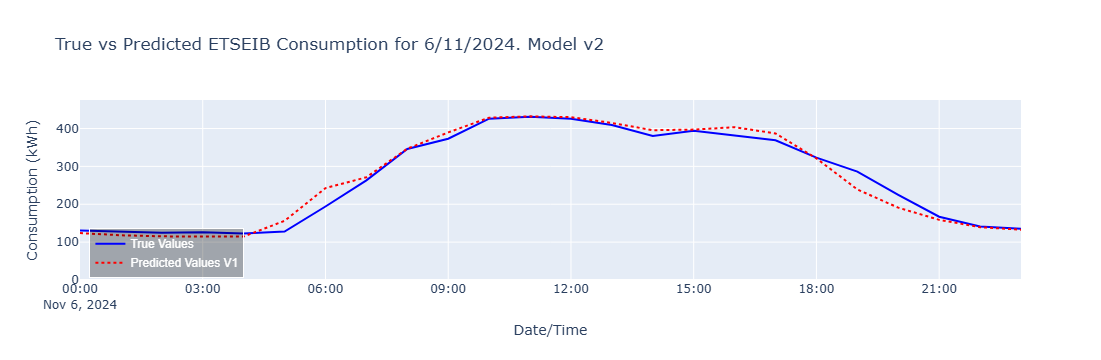

In [222]:
from sklearn.feature_selection import RFE


import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the trace for the actual consumption (True Values)
fig.add_trace(go.Scatter(x=input_data.index, y=real_etseib_consumption, mode='lines', name='True Values',
                         line=dict(color='blue', width=2)))

# Add the trace for the predicted consumption (Predicted Values)
fig.add_trace(go.Scatter(x=input_data.index, y=y_predict, mode='lines', name='Predicted Values V1',
                         line=dict(color='red', width=2, dash='dot')))  # 'dot' for less separated dashes



# Update layout for a more beautiful plot
fig.update_layout(
    title='True vs Predicted ETSEIB Consumption for 6/11/2024. Model v2',
    xaxis_title='Date/Time',
    yaxis_title='Consumption (kWh)',
    yaxis=dict(range=[0, max(max(real_etseib_consumption), max(y_predict)) * 1.1]),
    template='plotly',  # dark theme, can change to 'plotly' for light theme
    hovermode='x unified',  # hover over to show values for both lines at a time
    legend=dict(
        x=0.01, y=0.01,  # position of legend
        traceorder='normal',
        font=dict(family="Arial", size=12, color="white"),
        bgcolor='rgba(0, 0, 0, 0.3)',
        bordercolor='white',
        borderwidth=1
    ),
)

# Show the plot
fig.show()